NEED TO RUN AGAIN EVERYTHING OF ACTIVITY WITH `activity_aligned` !!!!!!

In [20]:
import os


# Import libraries from general conda environment
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import adjusted_rand_score, confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
from scipy.optimize import linear_sum_assignment
import copy as copy
import pickle
from functools import reduce
from pathlib import Path

# Import libraries from UnitedNet
import sys
import os
from unitednet.interface import UnitedNet
from unitednet.configs import *
from unitednet.data import partitions,save_umap,generate_adata
from unitednet.scripts import ordered_cmat,assignmene_align

# Import for SHAPs
import shap
import torch
import torch.nn as nn
from unitednet.modules import submodel_trans, submodel_clus
from unitednet.data import save_obj, load_obj, type_specific_mean
from unitednet.plots import markers_chord_plot,type_relevance_chord_plot,feature_relevance_chord_plot,merge_sub_feature

# Import for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors

# Import for more detailed plotting
import matplotlib as mpl
from  matplotlib.ticker import FuncFormatter
# Import STRINGdb for PPI network models and Networkx for visualisation and potential graph analysis
import stringdb
import networkx as nx
import math
from scipy.spatial import distance
import anndata
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
import gseapy

# RNA

In [21]:
adata = sc.read_h5ad('../Data/perturbmap_stomicsdb/GSM5808054_10x_Visium_processed.h5ad')
adata

# Load phenotypic data
pheno = pd.read_csv("../Data/PertMap_metadata/spot_annotation_KP1.csv")
pheno = pheno.set_index("barcode")

# Add phenotypes to adata.obs
adata.obs["phenotypes"] = adata.obs.index.map(pheno["phenotypes"])
adata.obs['kmeans'] = adata.obs.index.map(pheno["kmeans"])

# Remove NA entries from phenotypes
adata_filtered = adata[adata.obs["phenotypes"].notna()].copy()

# Remove normal cells from phenotypes
adata_filtered = adata[(adata.obs["kmeans"] != "normal")].copy()
adata_filtered = adata_filtered[adata_filtered.obs["phenotypes"].notna()].copy()

In [22]:
adata_filtered

AnnData object with n_obs × n_vars = 407 × 32289
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

In [23]:
sc.pp.normalize_total(adata_filtered, inplace=True)
sc.pp.log1p(adata_filtered)

In [24]:
adata_tmp = adata_filtered.copy()
sc.pp.highly_variable_genes(adata_tmp, n_top_genes=2500)

# Start with the HVG mask
hvg_mask = adata_tmp.var["highly_variable"].copy()

# List of genes to force-keep
forced_genes = ["Tgfbr2", "Jak2", 'Socs1', 'Ifngr2']

# Ensure they exist in the var_names
for g in forced_genes:
    if g in adata_tmp.var_names:
        hvg_mask.loc[g] = True
    else:
        print(f"⚠️ Gene {g} not found in adata.var_names")

# Now subset using the updated mask
adata_hvg = adata_filtered[:, hvg_mask].copy()
adata_hvg = adata_hvg[adata_hvg.obs["phenotypes"].notna()].copy()

print(f"Final HVG count: {hvg_mask.sum()}")  # should be 1004 if both are present

Final HVG count: 2504


In [25]:
sc.pp.pca(adata_hvg )
sc.pp.neighbors(adata_hvg)
sc.tl.umap(adata_hvg)
sc.tl.leiden(adata_hvg, key_added="clusters",  directed=False, n_iterations=2)

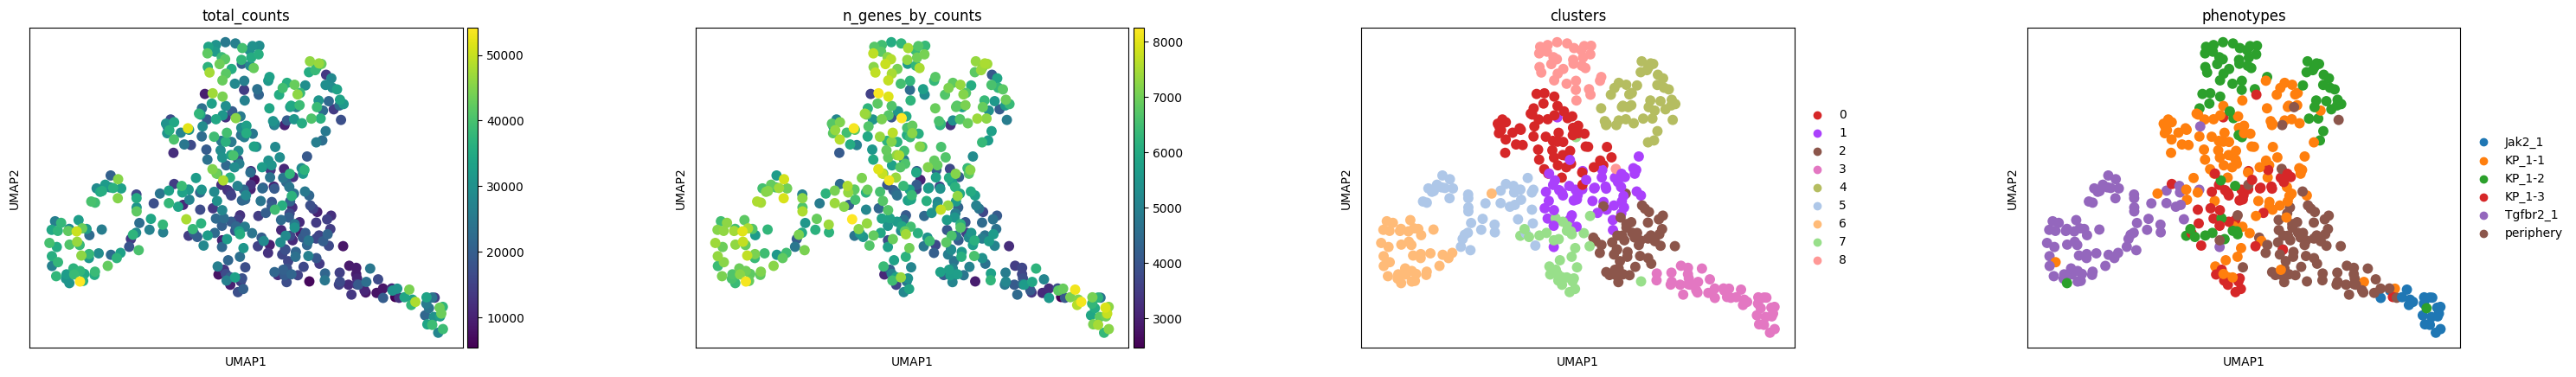

In [8]:
sc.pl.umap(adata_hvg, color=["total_counts", "n_genes_by_counts", "clusters", 'phenotypes'], wspace=0.4)

In [26]:
adata_hvg

AnnData object with n_obs × n_vars = 407 × 2504
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

In [10]:
adata_hvg.write_h5ad('../Data/perturbmap_stomicsdb/RNA_adata_myrthe.h5ad')

# Niche

In [11]:
# same folder as your notebook
from niche_unitednet import run_niche_pipeline

niche = run_niche_pipeline(
    adata_in=adata_hvg,
    # output_path="../Data/processedData3/niche_modality.h5ad",
    k=15,
    distance_type="euclidean",
    weight_mode="inverse",   # or "uniform" / "gaussian"
    include_self=False,
    pheno_csv="../Data/PertMap_metadata/spot_annotation_KP1.csv",
    pheno_barcode_col="barcode",
    pheno_cols=["phenotypes", "kmeans"],
    # reference_adata_path='../Data/processedData3/rna_modality.h5ad',       # or "reference.h5ad"
    relabel_barcodes_to_reference=False,
    overwrite=True,
    log_level="INFO",
)
niche

2025-12-04 13:24:18,502 - INFO - Using provided AnnData object: (407, 2504)
2025-12-04 13:24:18,615 - INFO - Normalized barcodes.
2025-12-04 13:24:18,618 - INFO - Barcode overlap: 407 / 407 cells
2025-12-04 13:24:18,619 - INFO - Added phenotype column: phenotypes (407/407 cells matched, type: category)
2025-12-04 13:24:18,620 - INFO - Added phenotype column: kmeans (407/407 cells matched, type: category)
2025-12-04 13:24:18,639 - INFO - Computed 4947 edges (k=15, metric=euclidean).


X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 407 × 2504
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'log1p', 'phenotypes_colors', 'modality', 'niche_method'
    obsm: 'X_pca', 'X_umap', 'spatial'

In [12]:
niche

AnnData object with n_obs × n_vars = 407 × 2504
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'log1p', 'phenotypes_colors', 'modality', 'niche_method'
    obsm: 'X_pca', 'X_umap', 'spatial'

In [13]:
niche.write_h5ad('../Data/perturbmap_stomicsdb/niche_adata_myrthe.h5ad')

# Activity

In [27]:
from scminer_activity_to_adata import (
    create_adata_from_activity_matrix,
    compare_adata_objects,
)

import anndata as ad

In [28]:
activity = create_adata_from_activity_matrix(
    adata_hvg,
    "../Data/scMINER/PerturbMap_scminer_mtx_kp12.csv"
)
compare_adata_objects(adata, activity)
activity.write("../Data/scMINER/perturbmap_activity_matrix_full_v3.h5ad")

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
... storing 'phenotypes' as categorical
... storing 'kmeans' as categorical
... storing 'activity_type' as categorical


Found 407 common cells between datasets
Created new AnnData object:
  - Shape: (407, 8714)
  - Observations (cells): 407
  - Variables (activities): 8714
  - Preserved metadata: obs(18), obsm(3), obsp(2), uns(11)

Verifying alignment:
  - First 3 cell barcodes in new_adata: ['AAACCTCATGAAGTTG-1', 'AAACGAGACGGTTGAT-1', 'AAACTCGTGATATAAG-1']
  - First 3 cell barcodes in activity data: ['AAACCTCATGAAGTTG-1', 'AAACGAGACGGTTGAT-1', 'AAACTCGTGATATAAG-1']
  - Spatial coordinates shape: (407, 2)
=== AnnData Comparison ===
Original shape: (4992, 32289)
New shape: (407, 8714)
Common cells: 407
Original .obs columns: ['in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans']
New .obs columns: ['i

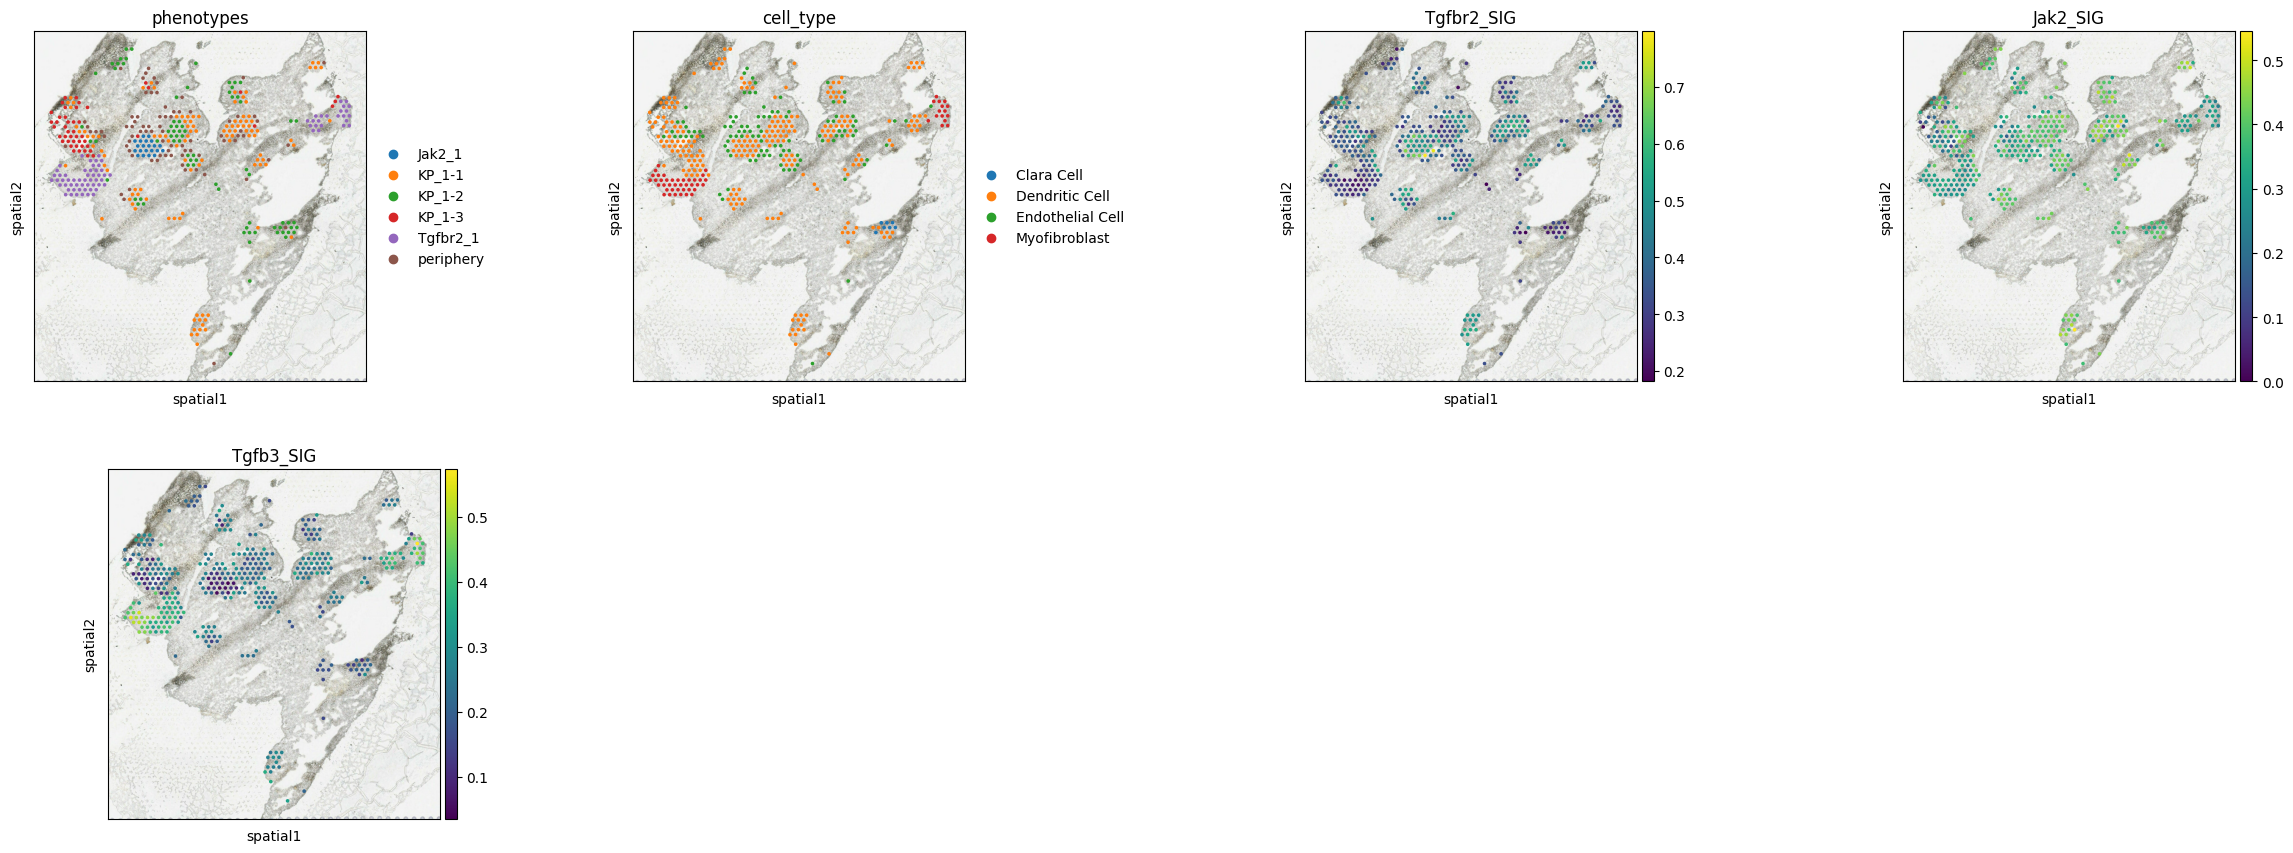

In [25]:
sc.pl.spatial(activity, img_key="hires", color=["phenotypes", "cell_type", 'Tgfbr2_SIG', 'Jak2_SIG', 'Tgfb3_SIG'])

In [29]:
# Run HVG selection on activity matrix, independently from the RNA modality
sc.pp.highly_variable_genes(activity, n_top_genes=2500)

# Copy the HVG mask
hvg_mask = activity.var["highly_variable"].copy()

# Force-include these genes
forced_genes = ["Tgfbr2_SIG", "Jak2_SIG", "Socs1_SIG", "Ifngr2_SIG"]

for g in forced_genes:
    if g in activity.var_names:
        hvg_mask.loc[g] = True
    else:
        print(f"⚠️ Gene {g} not found in activity.var_names")

# Subset with the updated mask
activity_hvg = activity[:, hvg_mask].copy()

print(f"Final HVG count: {hvg_mask.sum()}")

Final HVG count: 2503


In [30]:
common_spots = adata_hvg.obs_names.intersection(activity_hvg.obs_names)

# If you expect perfect overlap, this ensures the same order as 'smaller'
activity_aligned = activity_hvg[common_spots].copy()
activity_aligned = activity_aligned[adata_hvg.obs_names.intersection(activity_aligned.obs_names)].copy()

print("Final shape (spots × HVGs):", activity_aligned.n_obs, "×", activity_aligned.n_vars)

Final shape (spots × HVGs): 407 × 2503


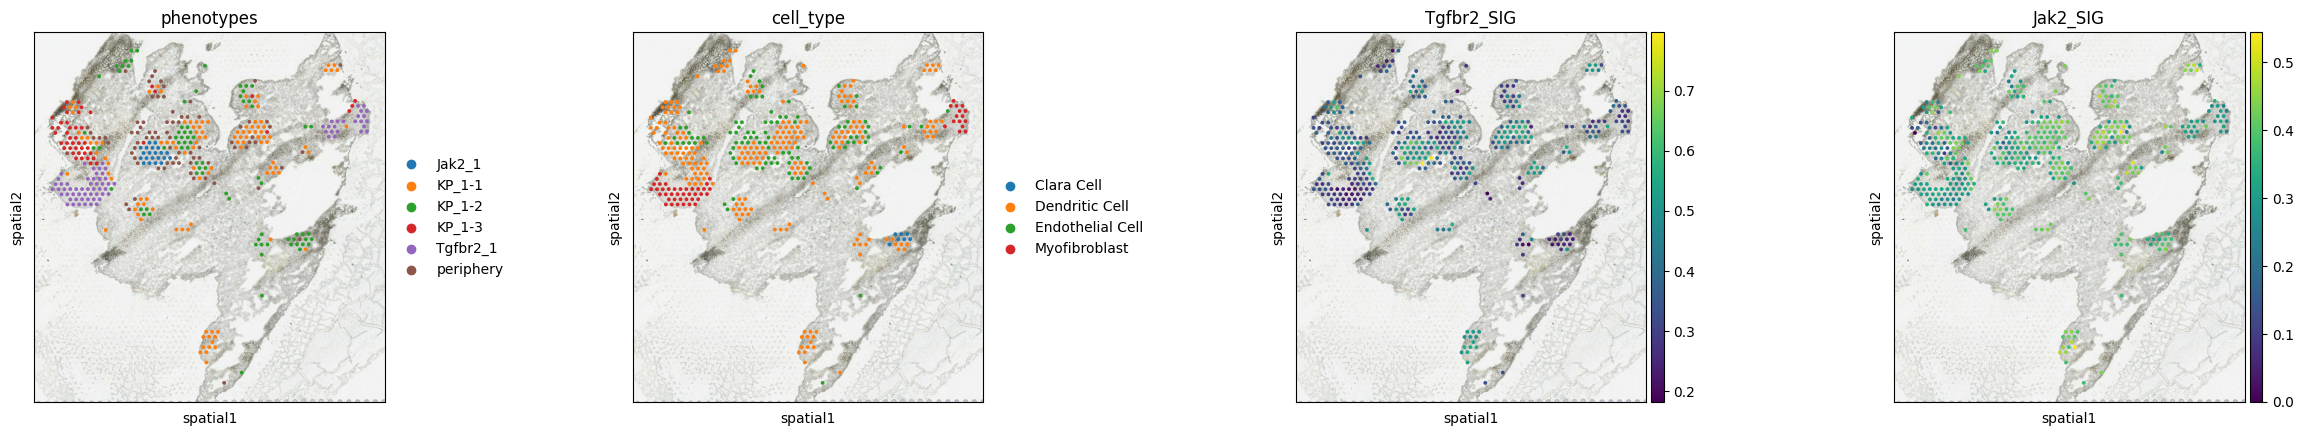

In [28]:
sc.pl.spatial(activity_aligned, img_key="hires", color=["phenotypes", "cell_type", 'Tgfbr2_SIG', 'Jak2_SIG'])

In [18]:
activity.var_names = (
    activity.var_names.astype(str)            # ensure string
    .str.replace(r'(_TF|_SIG)$', '', regex=True)
)

In [19]:
activity.write_h5ad('../Data/perturbmap_stomicsdb/activity_adata_myrthe.h5ad')

# GSEAPY

## RNA

In [46]:
# minimal deps: scanpy, gseapy, pandas, matplotlib
import scanpy as sc
import pandas as pd
from pathlib import Path
import gseapy as gp
from gseapy import dotplot

# ---- settings you will likely tweak ----
CASE        = "Tgfbr2_1"
CONTROLS    = ["KP_1-1", "KP_1-2", "KP_1-3", "periphery"]
GROUPBY     = "phenotypes"     # column in adata_hvg.obs
ALPHA       = 0.05
LIBRARIES   = ["BioPlanet_2019"]  # add more if you want, e.g. "KEGG_2021_Mouse"
OUTDIR      = Path("./GSEAPY_Enrichr_Only")
# ----------------------------------------

OUTDIR.mkdir(parents=True, exist_ok=True)
summary_rows = []

for ctrl in CONTROLS:
    cmp_name = f"{CASE}_vs_{ctrl}"
    print(f"[INFO] {cmp_name}: DE + Enrichr")

    # 1) rank genes (t-test) for this comparison
    sc.tl.rank_genes_groups(
        adata_hvg,
        groupby=GROUPBY,
        groups=[CASE],               # must be a sequence
        reference=ctrl,
        method="t-test",
        use_raw=False,
        tie_correct=True
    )

    # 2) extract and filter DEGs
    res_df = sc.get.rank_genes_groups_df(adata_hvg, group=CASE)
    de_df  = res_df.loc[res_df["pvals_adj"] < ALPHA, ["names", "scores", "logfoldchanges", "pvals", "pvals_adj"]].copy()
    genes  = de_df["names"].dropna().drop_duplicates().tolist()

    # quick guard: if no genes pass, skip gracefully
    if len(genes) == 0:
        print(f"[WARN] No DEGs at padj<{ALPHA} for {cmp_name}. Skipping Enrichr.")
        continue

    # 3) run Enrichr for each library and save outputs
    run_dir = OUTDIR / cmp_name
    run_dir.mkdir(parents=True, exist_ok=True)
    de_df.to_csv(run_dir / "DEGs_padj_lt_0.05.csv", index=False)

    for lib in LIBRARIES:
        try:
            enr = gp.enrichr(gene_list=genes, gene_sets=lib, cutoff=ALPHA)
            enr_res = enr.results.copy() if hasattr(enr, "results") else pd.DataFrame()

            # save table
            res_csv = run_dir / f"enrichr_{lib}.csv"
            enr_res.to_csv(res_csv, index=False)

            # make a small dotplot (top 20 terms if available)
            if not enr_res.empty:
                # sort by Adjusted P-value if present
                sort_col = "Adjusted P-value" if "Adjusted P-value" in enr_res.columns else "P-value"
                enr_res_sorted = enr_res.sort_values(sort_col).head(20)
                ax = dotplot(
                    enr_res_sorted,
                    title=f"{lib} — {cmp_name} (RNA)",
                    cmap="viridis_r",
                    size=10,
                    figsize=(5,6)
                )
                figpath = run_dir / f"dotplot_{lib}.png"
                ax.figure.savefig(figpath, dpi=200, bbox_inches="tight")
                ax.figure.clf()

            # add to summary
            if not enr_res.empty:
                keep_cols = ["Term","Overlap","P-value","Adjusted P-value","Combined Score"]
                for _, row in enr_res.head(10).iterrows():  # top 10 per lib to keep summary small
                    summary_rows.append({
                        "comparison": cmp_name,
                        "library": lib,
                        "term": row.get("Term"),
                        "pval": row.get("P-value"),
                        "padj": row.get("Adjusted P-value"),
                        "combined_score": row.get("Combined Score"),
                        "overlap": row.get("Overlap")
                    })
        except Exception as e:
            print(f"[WARN] Enrichr failed for {cmp_name} :: {lib}: {e}")

# write a compact cross-comparison summary (optional)
if summary_rows:
    summary = pd.DataFrame(summary_rows)
    summary = summary.sort_values(["library","comparison","padj"], na_position="last")
    summary.to_csv(OUTDIR / "enrichr_summary_top10_per_library.csv", index=False)
    print(f"[OK] Summary saved: {OUTDIR/'enrichr_summary_top10_per_library.csv'}")
else:
    print("[WARN] No enrichment results collected.")

[INFO] Tgfbr2_1_vs_KP_1-1: DE + Enrichr
[INFO] Tgfbr2_1_vs_KP_1-2: DE + Enrichr
[INFO] Tgfbr2_1_vs_KP_1-3: DE + Enrichr
[INFO] Tgfbr2_1_vs_periphery: DE + Enrichr
[OK] Summary saved: GSEAPY_Enrichr_Only/enrichr_summary_top10_per_library.csv


<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

In [47]:
# 2x2 grid composer for Enrichr dotplots
# Requires: matplotlib, pillow (pip install pillow)
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

OUTDIR = Path("./GSEAPY_Enrichr_Only")
COMPARISONS = [
    "Tgfbr2_1_vs_KP_1-1",
    "Tgfbr2_1_vs_KP_1-2",
    "Tgfbr2_1_vs_KP_1-3",
    "Tgfbr2_1_vs_periphery",
]
LIB = "BioPlanet_2019"  # change if you composed KEGG etc.

def img_path(cmp_name, lib=LIB):
    p = OUTDIR / cmp_name / f"dotplot_{lib}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path is None:
        ax.text(
            0.5, 0.5, f"{title}\n(no plot)",
            ha="center", va="center", fontsize=11, color="gray",
            transform=ax.transAxes,
            bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
        )
    else:
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
        except Exception:
            ax.text(
                0.5, 0.5, f"{title}\n(load error)",
                ha="center", va="center", fontsize=11, color="gray",
                transform=ax.transAxes,
                bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
            )

# ---- make 2x2 grid ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)

# If fewer than 4 comparisons, blank the remaining axes
for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTDIR / f"dotplots_2x2_{LIB}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# (optional) also a 1-page PDF
pdf_path = OUTDIR / f"dotplots_2x2_{LIB}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: GSEAPY_Enrichr_Only/dotplots_2x2_BioPlanet_2019.png
2025-10-25 06:41:17,550 - INFO - maxp pruned
2025-10-25 06:41:17,555 - INFO - cmap pruned
2025-10-25 06:41:17,555 - INFO - kern dropped
2025-10-25 06:41:17,555 - INFO - post pruned
2025-10-25 06:41:17,556 - INFO - FFTM dropped
2025-10-25 06:41:17,557 - INFO - GPOS pruned
2025-10-25 06:41:17,559 - INFO - GSUB pruned
2025-10-25 06:41:17,562 - INFO - glyf pruned
2025-10-25 06:41:17,562 - INFO - Added gid0 to subset
2025-10-25 06:41:17,563 - INFO - Added first four glyphs to subset
2025-10-25 06:41:17,563 - INFO - Closing glyph list over 'MATH': 23 glyphs before
2025-10-25 06:41:17,563 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'nonmarkingreturn', 'one', 'p', 'r', 's', 'space', 'three', 'two', 'underscore', 'v', 'y']
2025-10-25 06:41:17,564 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 46, 51, 55, 66, 69, 72, 73, 74, 75, 76, 83, 85, 86, 89, 92]
2025-10-25 06:41:17,564

In [48]:
# --- RNA Enrichr + GSEApy barplot (simple & robust) ---
# deps: scanpy, gseapy, pandas, matplotlib
import scanpy as sc
import pandas as pd
from pathlib import Path
import gseapy as gp
from gseapy import barplot
import matplotlib.pyplot as plt

# ---------------- settings ----------------
CASE        = "Tgfbr2_1"
CONTROLS    = ["KP_1-1", "KP_1-2", "KP_1-3", "periphery"]
GROUPBY     = "phenotypes"
ALPHA       = 0.05
TOP_N       = 20                        # top terms to show in the barplot
LIBRARIES   = ["BioPlanet_2019"]        # add "KEGG_2021_Mouse" or "KEGG_2021_Human" if needed
OUTDIR      = Path("./GSEAPY_Enrichr_Only_RNA_Barplots")
# -------------------------------------------

# 0) ensure normalization/log1p (no-op if already normalized)
if "log1p" not in adata_hvg.uns:
    sc.pp.normalize_total(adata_hvg, target_sum=1e4)
    sc.pp.log1p(adata_hvg)

OUTDIR.mkdir(parents=True, exist_ok=True)

for ctrl in CONTROLS:
    cmp_name = f"{CASE}_vs_{ctrl}"
    print(f"[INFO] {cmp_name}: RNA DE + Enrichr (barplot)")

    # 1) DE: t-test case vs reference
    sc.tl.rank_genes_groups(
        adata_hvg,
        groupby=GROUPBY,
        groups=[CASE],         # must be a sequence
        reference=ctrl,
        method="t-test",
        use_raw=False,
        tie_correct=True
    )

    # 2) collect DEGs @ FDR < ALPHA
    res_df = sc.get.rank_genes_groups_df(adata_hvg, group=CASE)
    de_df  = res_df.loc[res_df["pvals_adj"] < ALPHA, ["names", "scores", "logfoldchanges", "pvals", "pvals_adj"]].copy()
    genes  = de_df["names"].dropna().drop_duplicates().tolist()

    run_dir = OUTDIR / cmp_name
    run_dir.mkdir(parents=True, exist_ok=True)
    de_df.to_csv(run_dir / "DEGs_padj_lt_0.05.csv", index=False)

    if len(genes) == 0:
        print(f"[WARN] No DEGs at padj<{ALPHA} for {cmp_name}. Skipping Enrichr.")
        continue

    # 3) Enrichr + barplot per library
    for lib in LIBRARIES:
        try:
            enr = gp.enrichr(gene_list=genes, gene_sets=lib, cutoff=ALPHA)
            enr_res = enr.results if hasattr(enr, "results") else pd.DataFrame()

            # save table
            res_csv = run_dir / f"enrichr_{lib}.csv"
            enr_res.to_csv(res_csv, index=False)

            if enr_res.empty:
                print(f"[WARN] No enrichment terms for {cmp_name} :: {lib}")
                continue

            # take top-N by Adjusted P-value (fallback to P-value)
            sort_col = "Adjusted P-value" if "Adjusted P-value" in enr_res.columns else (
                       "P-value" if "P-value" in enr_res.columns else None)
            plot_df = enr_res.copy()
            if sort_col:
                plot_df = plot_df.sort_values(sort_col, ascending=True).head(TOP_N)

            # barplot (same style you used)
            ax = barplot(
                plot_df,
                title=f"{lib} — {cmp_name} (RNA)",
                figsize=(4, 5),
                color="darkblue"
            )
            figpath = run_dir / f"barplot_{lib}.png"
            ax.figure.savefig(figpath, dpi=200, bbox_inches="tight")
            plt.close(ax.figure)
            print(f"[OK] Saved: {figpath}")

        except Exception as e:
            print(f"[WARN] Enrichr/barplot failed for {cmp_name} :: {lib}: {e}")

print("[OK] RNA barplots done.")


[INFO] Tgfbr2_1_vs_KP_1-1: RNA DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_RNA_Barplots/Tgfbr2_1_vs_KP_1-1/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_1_vs_KP_1-2: RNA DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_RNA_Barplots/Tgfbr2_1_vs_KP_1-2/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_1_vs_KP_1-3: RNA DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_RNA_Barplots/Tgfbr2_1_vs_KP_1-3/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_1_vs_periphery: RNA DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_RNA_Barplots/Tgfbr2_1_vs_periphery/barplot_BioPlanet_2019.png
[OK] RNA barplots done.


In [50]:
# 2x2 grid composer for Enrichr BARPLOTS (RNA)
# Requires: matplotlib, pillow (pip install pillow)
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

OUTDIR = Path("./GSEAPY_Enrichr_Only_RNA_Barplots")  # <-- RNA outputs

COMPARISONS = [
    "Tgfbr2_1_vs_KP_1-1",
    "Tgfbr2_1_vs_KP_1-2",
    "Tgfbr2_1_vs_KP_1-3",
    "Tgfbr2_1_vs_periphery",
]
LIB = "BioPlanet_2019"  # change if you composed other libs (e.g., "KEGG_2021_Mouse")

def img_path(cmp_name, lib=LIB):
    p = OUTDIR / cmp_name / f"barplot_{lib}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path is None:
        ax.text(
            0.5, 0.5, f"{title}\n(no plot)",
            ha="center", va="center", fontsize=11, color="gray",
            transform=ax.transAxes,
            bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
        )
    else:
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
        except Exception:
            ax.text(
                0.5, 0.5, f"{title}\n(load error)",
                ha="center", va="center", fontsize=11, color="gray",
                transform=ax.transAxes,
                bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
            )

# ---- make 2x2 grid (PNG) ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)
for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTDIR / f"barplots_2x2_{LIB}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# ---- (optional) 1-page PDF ----
pdf_path = OUTDIR / f"barplots_2x2_{LIB}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: GSEAPY_Enrichr_Only_RNA_Barplots/barplots_2x2_BioPlanet_2019.png
2025-10-25 06:41:47,877 - INFO - maxp pruned
2025-10-25 06:41:47,882 - INFO - cmap pruned
2025-10-25 06:41:47,882 - INFO - kern dropped
2025-10-25 06:41:47,882 - INFO - post pruned
2025-10-25 06:41:47,882 - INFO - FFTM dropped
2025-10-25 06:41:47,884 - INFO - GPOS pruned
2025-10-25 06:41:47,886 - INFO - GSUB pruned
2025-10-25 06:41:47,889 - INFO - glyf pruned
2025-10-25 06:41:47,890 - INFO - Added gid0 to subset
2025-10-25 06:41:47,890 - INFO - Added first four glyphs to subset
2025-10-25 06:41:47,890 - INFO - Closing glyph list over 'MATH': 23 glyphs before
2025-10-25 06:41:47,890 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'nonmarkingreturn', 'one', 'p', 'r', 's', 'space', 'three', 'two', 'underscore', 'v', 'y']
2025-10-25 06:41:47,891 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 46, 51, 55, 66, 69, 72, 73, 74, 75, 76, 83, 85, 86, 89, 92]
2025-10-25

## Niche

In [51]:
# minimal deps: scanpy, gseapy, pandas, matplotlib
import scanpy as sc
import pandas as pd
from pathlib import Path
import gseapy as gp
from gseapy import dotplot

# ---- settings ----
CASE        = "Tgfbr2_1"
CONTROLS    = ["KP_1-1", "KP_1-2", "KP_1-3", "periphery"]
GROUPBY     = "phenotypes"
ALPHA       = 0.05
LIBRARIES   = ["BioPlanet_2019"]  # add more (e.g., "KEGG_2021_Mouse")
OUTDIR      = Path("./GSEAPY_Enrichr_Only_Niche")
# ------------------

# (optional) quick normalization if your 'niche' object isn't log-normalized yet
if "log1p" not in niche.uns:
    sc.pp.normalize_total(niche, target_sum=1e4)
    sc.pp.log1p(niche)

OUTDIR.mkdir(parents=True, exist_ok=True)
summary_rows = []

for ctrl in CONTROLS:
    cmp_name = f"{CASE}_vs_{ctrl}"
    print(f"[INFO] {cmp_name}: Niche DE + Enrichr")

    # 1) rank genes (t-test) for this comparison
    sc.tl.rank_genes_groups(
        niche,
        groupby=GROUPBY,
        groups=[CASE],               # must be a sequence
        reference=ctrl,
        method="t-test",
        use_raw=False,
        tie_correct=True
    )

    # 2) extract and filter DEGs
    res_df = sc.get.rank_genes_groups_df(niche, group=CASE)
    de_df  = res_df.loc[res_df["pvals_adj"] < ALPHA, ["names", "scores", "logfoldchanges", "pvals", "pvals_adj"]].copy()
    genes  = de_df["names"].dropna().drop_duplicates().tolist()

    if len(genes) == 0:
        print(f"[WARN] No DEGs at padj<{ALPHA} for {cmp_name}. Skipping Enrichr.")
        continue

    # 3) Enrichr per library + dotplot
    run_dir = OUTDIR / cmp_name
    run_dir.mkdir(parents=True, exist_ok=True)
    de_df.to_csv(run_dir / "DEGs_padj_lt_0.05.csv", index=False)

    for lib in LIBRARIES:
        try:
            enr = gp.enrichr(gene_list=genes, gene_sets=lib, cutoff=ALPHA)
            enr_res = enr.results.copy() if hasattr(enr, "results") else pd.DataFrame()

            # save table
            res_csv = run_dir / f"enrichr_{lib}.csv"
            enr_res.to_csv(res_csv, index=False)

            # dotplot (top 20)
            if not enr_res.empty:
                sort_col = "Adjusted P-value" if "Adjusted P-value" in enr_res.columns else "P-value"
                enr_res_sorted = enr_res.sort_values(sort_col).head(20)
                ax = dotplot(
                    enr_res_sorted,
                    title=f"{lib} — {cmp_name} (Niche)",
                    cmap="viridis_r",
                    size=10,
                    figsize=(5,6)
                )
                figpath = run_dir / f"dotplot_{lib}.png"
                ax.figure.savefig(figpath, dpi=200, bbox_inches="tight")
                ax.figure.clf()

            # add to summary (top 10)
            if not enr_res.empty:
                for _, row in enr_res.head(10).iterrows():
                    summary_rows.append({
                        "comparison": cmp_name,
                        "library": lib,
                        "term": row.get("Term"),
                        "pval": row.get("P-value"),
                        "padj": row.get("Adjusted P-value"),
                        "combined_score": row.get("Combined Score"),
                        "overlap": row.get("Overlap")
                    })
        except Exception as e:
            print(f"[WARN] Enrichr failed for {cmp_name} :: {lib}: {e}")

# summary CSV
if summary_rows:
    summary = pd.DataFrame(summary_rows).sort_values(["library","comparison","padj"], na_position="last")
    summary.to_csv(OUTDIR / "enrichr_summary_top10_per_library.csv", index=False)
    print(f"[OK] Summary saved: {OUTDIR/'enrichr_summary_top10_per_library.csv'}")
else:
    print("[WARN] No enrichment results collected.")

[INFO] Tgfbr2_1_vs_KP_1-1: Niche DE + Enrichr
[INFO] Tgfbr2_1_vs_KP_1-2: Niche DE + Enrichr
[INFO] Tgfbr2_1_vs_KP_1-3: Niche DE + Enrichr
[INFO] Tgfbr2_1_vs_periphery: Niche DE + Enrichr
[OK] Summary saved: GSEAPY_Enrichr_Only_Niche/enrichr_summary_top10_per_library.csv


<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

In [52]:
# 2x2 grid composer for Enrichr dotplots
# Requires: matplotlib, pillow (pip install pillow)
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

OUTDIR = Path("./GSEAPY_Enrichr_Only_Niche")
COMPARISONS = [
    "Tgfbr2_1_vs_KP_1-1",
    "Tgfbr2_1_vs_KP_1-2",
    "Tgfbr2_1_vs_KP_1-3",
    "Tgfbr2_1_vs_periphery",
]
LIB = "BioPlanet_2019"  # change if you composed KEGG etc.

def img_path(cmp_name, lib=LIB):
    p = OUTDIR / cmp_name / f"dotplot_{lib}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path is None:
        ax.text(
            0.5, 0.5, f"{title}\n(no plot)",
            ha="center", va="center", fontsize=11, color="gray",
            transform=ax.transAxes,
            bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
        )
    else:
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
        except Exception:
            ax.text(
                0.5, 0.5, f"{title}\n(load error)",
                ha="center", va="center", fontsize=11, color="gray",
                transform=ax.transAxes,
                bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
            )

# ---- make 2x2 grid ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)

# If fewer than 4 comparisons, blank the remaining axes
for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTDIR / f"dotplots_2x2_{LIB}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# (optional) also a 1-page PDF
pdf_path = OUTDIR / f"dotplots_2x2_{LIB}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: GSEAPY_Enrichr_Only_Niche/dotplots_2x2_BioPlanet_2019.png
2025-10-25 06:42:20,169 - INFO - maxp pruned
2025-10-25 06:42:20,174 - INFO - cmap pruned
2025-10-25 06:42:20,174 - INFO - kern dropped
2025-10-25 06:42:20,174 - INFO - post pruned
2025-10-25 06:42:20,174 - INFO - FFTM dropped
2025-10-25 06:42:20,176 - INFO - GPOS pruned
2025-10-25 06:42:20,177 - INFO - GSUB pruned
2025-10-25 06:42:20,181 - INFO - glyf pruned
2025-10-25 06:42:20,182 - INFO - Added gid0 to subset
2025-10-25 06:42:20,182 - INFO - Added first four glyphs to subset
2025-10-25 06:42:20,182 - INFO - Closing glyph list over 'MATH': 23 glyphs before
2025-10-25 06:42:20,182 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'nonmarkingreturn', 'one', 'p', 'r', 's', 'space', 'three', 'two', 'underscore', 'v', 'y']
2025-10-25 06:42:20,183 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 46, 51, 55, 66, 69, 72, 73, 74, 75, 76, 83, 85, 86, 89, 92]
2025-10-25 06:42:

In [53]:
# --- Niche Enrichr + GSEApy barplot (simple & robust) ---
# deps: scanpy, gseapy, pandas, matplotlib
import scanpy as sc
import pandas as pd
from pathlib import Path
import gseapy as gp
from gseapy import barplot
import matplotlib.pyplot as plt

# ---------------- settings ----------------
CASE        = "Tgfbr2_1"
CONTROLS    = ["KP_1-1", "KP_1-2", "KP_1-3", "periphery"]
GROUPBY     = "phenotypes"
ALPHA       = 0.05
TOP_N       = 20                       # top terms to show in the barplot
LIBRARIES   = ["BioPlanet_2019"]       # e.g., add "KEGG_2021_Mouse" or "KEGG_2021_Human"
OUTDIR      = Path("./GSEAPY_Enrichr_Only_Niche_Barplots")
# niche: your AnnData object (already loaded) must be named `niche`
# -------------------------------------------

# 0) ensure normalization/log1p (no-op if already normalized)
if "log1p" not in niche.uns:
    sc.pp.normalize_total(niche, target_sum=1e4)
    sc.pp.log1p(niche)

OUTDIR.mkdir(parents=True, exist_ok=True)

for ctrl in CONTROLS:
    cmp_name = f"{CASE}_vs_{ctrl}"
    print(f"[INFO] {cmp_name}: Niche DE + Enrichr (barplot)")

    # 1) DE: t-test case vs reference
    sc.tl.rank_genes_groups(
        niche,
        groupby=GROUPBY,
        groups=[CASE],         # must be a sequence
        reference=ctrl,
        method="t-test",
        use_raw=False,
        tie_correct=True
    )

    # 2) collect DEGs @ FDR < ALPHA
    res_df = sc.get.rank_genes_groups_df(niche, group=CASE)
    de_df  = res_df.loc[res_df["pvals_adj"] < ALPHA, ["names", "scores", "logfoldchanges", "pvals", "pvals_adj"]].copy()
    genes  = de_df["names"].dropna().drop_duplicates().tolist()

    run_dir = OUTDIR / cmp_name
    run_dir.mkdir(parents=True, exist_ok=True)
    de_df.to_csv(run_dir / "DEGs_padj_lt_0.05.csv", index=False)

    if len(genes) == 0:
        print(f"[WARN] No DEGs at padj<{ALPHA} for {cmp_name}. Skipping Enrichr.")
        continue

    # 3) Enrichr + barplot per library
    for lib in LIBRARIES:
        try:
            enr = gp.enrichr(gene_list=genes, gene_sets=lib, cutoff=ALPHA)
            enr_res = enr.results if hasattr(enr, "results") else pd.DataFrame()

            # save table
            res_csv = run_dir / f"enrichr_{lib}.csv"
            enr_res.to_csv(res_csv, index=False)

            if enr_res.empty:
                print(f"[WARN] No enrichment terms for {cmp_name} :: {lib}")
                continue

            # take top-N by Adjusted P-value (fallback to P-value)
            sort_col = "Adjusted P-value" if "Adjusted P-value" in enr_res.columns else (
                       "P-value" if "P-value" in enr_res.columns else None)
            plot_df = enr_res.copy()
            if sort_col:
                plot_df = plot_df.sort_values(sort_col, ascending=True).head(TOP_N)

            # barplot (your style)
            ax = barplot(
                plot_df,
                title=f"{lib} — {cmp_name} (Niche)",
                figsize=(4, 5),
                color="darkred"
            )
            figpath = run_dir / f"barplot_{lib}.png"
            ax.figure.savefig(figpath, dpi=200, bbox_inches="tight")
            plt.close(ax.figure)
            print(f"[OK] Saved: {figpath}")

        except Exception as e:
            print(f"[WARN] Enrichr/barplot failed for {cmp_name} :: {lib}: {e}")

print("[OK] Niche barplots done.")


[INFO] Tgfbr2_1_vs_KP_1-1: Niche DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_Niche_Barplots/Tgfbr2_1_vs_KP_1-1/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_1_vs_KP_1-2: Niche DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_Niche_Barplots/Tgfbr2_1_vs_KP_1-2/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_1_vs_KP_1-3: Niche DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_Niche_Barplots/Tgfbr2_1_vs_KP_1-3/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_1_vs_periphery: Niche DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_Niche_Barplots/Tgfbr2_1_vs_periphery/barplot_BioPlanet_2019.png
[OK] Niche barplots done.


In [54]:
# 2x2 grid composer for Enrichr BARPLOTS (Niche)
# Requires: matplotlib, pillow (pip install pillow)
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

# If you used the code I gave for Niche barplots, use this OUTDIR:
OUTDIR = Path("./GSEAPY_Enrichr_Only_Niche_Barplots")

COMPARISONS = [
    "Tgfbr2_1_vs_KP_1-1",
    "Tgfbr2_1_vs_KP_1-2",
    "Tgfbr2_1_vs_KP_1-3",
    "Tgfbr2_1_vs_periphery",
]
LIB = "BioPlanet_2019"  # change to "KEGG_2021_Mouse" etc. if needed

def img_path(cmp_name, lib=LIB):
    # NOTE: barplot filename pattern
    p = OUTDIR / cmp_name / f"barplot_{lib}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path is None:
        ax.text(
            0.5, 0.5, f"{title}\n(no plot)",
            ha="center", va="center", fontsize=11, color="gray",
            transform=ax.transAxes,
            bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
        )
    else:
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
        except Exception:
            ax.text(
                0.5, 0.5, f"{title}\n(load error)",
                ha="center", va="center", fontsize=11, color="gray",
                transform=ax.transAxes,
                bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
            )

# ---- make 2x2 grid (PNG) ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)

for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTDIR / f"barplots_2x2_{LIB}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# ---- (optional) 1-page PDF ----
pdf_path = OUTDIR / f"barplots_2x2_{LIB}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: GSEAPY_Enrichr_Only_Niche_Barplots/barplots_2x2_BioPlanet_2019.png
2025-10-25 06:42:50,528 - INFO - maxp pruned
2025-10-25 06:42:50,533 - INFO - cmap pruned
2025-10-25 06:42:50,534 - INFO - kern dropped
2025-10-25 06:42:50,534 - INFO - post pruned
2025-10-25 06:42:50,534 - INFO - FFTM dropped
2025-10-25 06:42:50,535 - INFO - GPOS pruned
2025-10-25 06:42:50,537 - INFO - GSUB pruned
2025-10-25 06:42:50,540 - INFO - glyf pruned
2025-10-25 06:42:50,541 - INFO - Added gid0 to subset
2025-10-25 06:42:50,541 - INFO - Added first four glyphs to subset
2025-10-25 06:42:50,541 - INFO - Closing glyph list over 'MATH': 23 glyphs before
2025-10-25 06:42:50,541 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'nonmarkingreturn', 'one', 'p', 'r', 's', 'space', 'three', 'two', 'underscore', 'v', 'y']
2025-10-25 06:42:50,542 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 46, 51, 55, 66, 69, 72, 73, 74, 75, 76, 83, 85, 86, 89, 92]
2025-10-

## Activity

In [31]:
# minimal deps: scanpy, gseapy, pandas, matplotlib
import scanpy as sc
import pandas as pd
from pathlib import Path
import gseapy as gp
from gseapy import dotplot

# ---- settings you will likely tweak ----
CASE        = "Tgfbr2_1"
CONTROLS    = ["KP_1-1", "KP_1-2", "KP_1-3", "periphery"]
GROUPBY     = "phenotypes"     
ALPHA       = 0.05
LIBRARIES   = ["BioPlanet_2019"]  # add more if you want, e.g. "KEGG_2021_Mouse"
OUTDIR      = Path("./GSEAPY_Enrichr_Only_Activity")
# ----------------------------------------

OUTDIR.mkdir(parents=True, exist_ok=True)
summary_rows = []

for ctrl in CONTROLS:
    cmp_name = f"{CASE}_vs_{ctrl}"
    print(f"[INFO] {cmp_name}: DE + Enrichr")

    # 1) rank genes (t-test) for this comparison
    sc.tl.rank_genes_groups(
        activity_aligned,
        groupby=GROUPBY,
        groups=[CASE],               # must be a sequence
        reference=ctrl,
        method="t-test",
        use_raw=False,
        tie_correct=True
    )

    # 2) extract and filter DEGs
    res_df = sc.get.rank_genes_groups_df(activity_aligned, group=CASE)
    de_df  = res_df.loc[res_df["pvals_adj"] < ALPHA, ["names", "scores", "logfoldchanges", "pvals", "pvals_adj"]].copy()
    genes  = de_df["names"].dropna().drop_duplicates().tolist()

    # quick guard: if no genes pass, skip gracefully
    if len(genes) == 0:
        print(f"[WARN] No DEGs at padj<{ALPHA} for {cmp_name}. Skipping Enrichr.")
        continue

    # 3) run Enrichr for each library and save outputs
    run_dir = OUTDIR / cmp_name
    run_dir.mkdir(parents=True, exist_ok=True)
    de_df.to_csv(run_dir / "DEGs_padj_lt_0.05.csv", index=False)

    for lib in LIBRARIES:
        try:
            enr = gp.enrichr(gene_list=genes, gene_sets=lib, cutoff=ALPHA)
            enr_res = enr.results.copy() if hasattr(enr, "results") else pd.DataFrame()

            # save table
            res_csv = run_dir / f"enrichr_{lib}.csv"
            enr_res.to_csv(res_csv, index=False)

            # make a small dotplot (top 20 terms if available)
            if not enr_res.empty:
                # sort by Adjusted P-value if present
                sort_col = "Adjusted P-value" if "Adjusted P-value" in enr_res.columns else "P-value"
                enr_res_sorted = enr_res.sort_values(sort_col).head(20)
                ax = dotplot(
                    enr_res_sorted,
                    title=f"{lib} — {cmp_name} (RNA)",
                    cmap="viridis_r",
                    size=10,
                    figsize=(5,6)
                )
                figpath = run_dir / f"dotplot_{lib}.png"
                ax.figure.savefig(figpath, dpi=200, bbox_inches="tight")
                ax.figure.clf()

            # add to summary
            if not enr_res.empty:
                keep_cols = ["Term","Overlap","P-value","Adjusted P-value","Combined Score"]
                for _, row in enr_res.head(10).iterrows():  # top 10 per lib to keep summary small
                    summary_rows.append({
                        "comparison": cmp_name,
                        "library": lib,
                        "term": row.get("Term"),
                        "pval": row.get("P-value"),
                        "padj": row.get("Adjusted P-value"),
                        "combined_score": row.get("Combined Score"),
                        "overlap": row.get("Overlap")
                    })
        except Exception as e:
            print(f"[WARN] Enrichr failed for {cmp_name} :: {lib}: {e}")

# write a compact cross-comparison summary (optional)
if summary_rows:
    summary = pd.DataFrame(summary_rows)
    summary = summary.sort_values(["library","comparison","padj"], na_position="last")
    summary.to_csv(OUTDIR / "enrichr_summary_top10_per_library.csv", index=False)
    print(f"[OK] Summary saved: {OUTDIR/'enrichr_summary_top10_per_library.csv'}")
else:
    print("[WARN] No enrichment results collected.")

[INFO] Tgfbr2_1_vs_KP_1-1: DE + Enrichr
[INFO] Tgfbr2_1_vs_KP_1-2: DE + Enrichr
[INFO] Tgfbr2_1_vs_KP_1-3: DE + Enrichr
[INFO] Tgfbr2_1_vs_periphery: DE + Enrichr
[WARN] No enrichment results collected.


In [43]:
# 2x2 grid composer for Enrichr dotplots
# Requires: matplotlib, pillow (pip install pillow)
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

OUTDIR = Path("./GSEAPY_Enrichr_Only_Activity")
COMPARISONS = [
    "Tgfbr2_1_vs_KP_1-1",
    "Tgfbr2_1_vs_KP_1-2",
    "Tgfbr2_1_vs_KP_1-3",
    "Tgfbr2_1_vs_periphery",
]
LIB = "BioPlanet_2019"  # change if you composed KEGG etc.

def img_path(cmp_name, lib=LIB):
    p = OUTDIR / cmp_name / f"dotplot_{lib}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path is None:
        ax.text(
            0.5, 0.5, f"{title}\n(no plot)",
            ha="center", va="center", fontsize=11, color="gray",
            transform=ax.transAxes,
            bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
        )
    else:
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
        except Exception:
            ax.text(
                0.5, 0.5, f"{title}\n(load error)",
                ha="center", va="center", fontsize=11, color="gray",
                transform=ax.transAxes,
                bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
            )

# ---- make 2x2 grid ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)

# If fewer than 4 comparisons, blank the remaining axes
for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTDIR / f"dotplots_2x2_{LIB}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# (optional) also a 1-page PDF
pdf_path = OUTDIR / f"dotplots_2x2_{LIB}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: GSEAPY_Enrichr_Only_Activity/dotplots_2x2_BioPlanet_2019.png
2025-10-25 06:31:08,206 - INFO - maxp pruned
2025-10-25 06:31:08,210 - INFO - cmap pruned
2025-10-25 06:31:08,211 - INFO - kern dropped
2025-10-25 06:31:08,211 - INFO - post pruned
2025-10-25 06:31:08,211 - INFO - FFTM dropped
2025-10-25 06:31:08,212 - INFO - GPOS pruned
2025-10-25 06:31:08,457 - INFO - GSUB pruned
2025-10-25 06:31:08,460 - INFO - glyf pruned
2025-10-25 06:31:08,461 - INFO - Added gid0 to subset
2025-10-25 06:31:08,461 - INFO - Added first four glyphs to subset
2025-10-25 06:31:08,461 - INFO - Closing glyph list over 'MATH': 23 glyphs before
2025-10-25 06:31:08,461 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'nonmarkingreturn', 'one', 'p', 'r', 's', 'space', 'three', 'two', 'underscore', 'v', 'y']
2025-10-25 06:31:08,462 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 46, 51, 55, 66, 69, 72, 73, 74, 75, 76, 83, 85, 86, 89, 92]
2025-10-25 06:

In [44]:
# --- Activity Enrichr + GSEApy barplot (simple & robust) ---
# deps: scanpy, gseapy, pandas, matplotlib
import scanpy as sc
import pandas as pd
from pathlib import Path
import gseapy as gp
from gseapy import barplot
import matplotlib.pyplot as plt

# ---------------- settings ----------------
CASE        = "Tgfbr2_1"
CONTROLS    = ["KP_1-1", "KP_1-2", "KP_1-3", "periphery"]
GROUPBY     = "phenotypes"
ALPHA       = 0.05
TOP_N       = 20
LIBRARIES   = ["BioPlanet_2019"]
OUTDIR      = Path("./GSEAPY_Enrichr_Only_Activity_Barplots")
# activity: your AnnData object (already loaded) must be named `activity`
# -------------------------------------------

# 0) ensure normalization/log1p (no-op if already normalized)
if "log1p" not in getattr(activity, "uns", {}):
    sc.pp.normalize_total(activity, target_sum=1e4)
    sc.pp.log1p(activity)

OUTDIR.mkdir(parents=True, exist_ok=True)

for ctrl in CONTROLS:
    cmp_name = f"{CASE}_vs_{ctrl}"
    print(f"[INFO] {cmp_name}: Activity DE + Enrichr (barplot)")

    # 1) DE: t-test case vs reference
    sc.tl.rank_genes_groups(
        activity,
        groupby=GROUPBY,
        groups=[CASE],
        reference=ctrl,
        method="t-test",
        use_raw=False,
        tie_correct=True
    )

    # 2) collect DEGs @ FDR < ALPHA
    res_df = sc.get.rank_genes_groups_df(activity, group=CASE)
    de_df  = res_df.loc[res_df["pvals_adj"] < ALPHA, ["names", "scores", "logfoldchanges", "pvals", "pvals_adj"]].copy()
    genes  = de_df["names"].dropna().drop_duplicates().tolist()

    run_dir = OUTDIR / cmp_name
    run_dir.mkdir(parents=True, exist_ok=True)
    de_df.to_csv(run_dir / "DEGs_padj_lt_0.05.csv", index=False)

    if len(genes) == 0:
        print(f"[WARN] No DEGs at padj<{ALPHA} for {cmp_name}. Skipping Enrichr.")
        continue

    # 3) Enrichr + barplot per library
    for lib in LIBRARIES:
        try:
            enr = gp.enrichr(gene_list=genes, gene_sets=lib, cutoff=ALPHA)
            enr_res = enr.results if hasattr(enr, "results") else pd.DataFrame()

            # save table
            res_csv = run_dir / f"enrichr_{lib}.csv"
            enr_res.to_csv(res_csv, index=False)

            if enr_res.empty:
                print(f"[WARN] No enrichment terms for {cmp_name} :: {lib}")
                continue

            # take top-N by Adjusted P-value (fallback to P-value)
            sort_col = "Adjusted P-value" if "Adjusted P-value" in enr_res.columns else (
                       "P-value" if "P-value" in enr_res.columns else None)
            plot_df = enr_res.copy()
            if sort_col:
                plot_df = plot_df.sort_values(sort_col, ascending=True).head(TOP_N)

            # barplot
            ax = barplot(
                plot_df,
                title=f"{lib} — {cmp_name} (Activity)",
                figsize=(4, 5),
                color="darkred"
            )
            figpath = run_dir / f"barplot_{lib}.png"
            ax.figure.savefig(figpath, dpi=200, bbox_inches="tight")
            plt.close(ax.figure)
            print(f"[OK] Saved: {figpath}")

        except Exception as e:
            print(f"[WARN] Enrichr/barplot failed for {cmp_name} :: {lib}: {e}")

print("[OK] Activity barplots done.")


[INFO] Tgfbr2_1_vs_KP_1-1: Activity DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_Activity_Barplots/Tgfbr2_1_vs_KP_1-1/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_1_vs_KP_1-2: Activity DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_Activity_Barplots/Tgfbr2_1_vs_KP_1-2/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_1_vs_KP_1-3: Activity DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_Activity_Barplots/Tgfbr2_1_vs_KP_1-3/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_1_vs_periphery: Activity DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_Activity_Barplots/Tgfbr2_1_vs_periphery/barplot_BioPlanet_2019.png
[OK] Activity barplots done.


In [45]:
# 2x2 grid composer for Enrichr BARPLOTS (Activity)
# Requires: matplotlib, pillow (pip install pillow)
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

# If you used the code I gave for Activity barplots, use this OUTDIR:
OUTDIR = Path("./GSEAPY_Enrichr_Only_Activity_Barplots")

COMPARISONS = [
    "Tgfbr2_1_vs_KP_1-1",
    "Tgfbr2_1_vs_KP_1-2",
    "Tgfbr2_1_vs_KP_1-3",
    "Tgfbr2_1_vs_periphery",
]
LIB = "BioPlanet_2019"  # change to "KEGG_2021_Mouse" etc. if needed

def img_path(cmp_name, lib=LIB):
    # NOTE: barplot filename pattern
    p = OUTDIR / cmp_name / f"barplot_{lib}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path is None:
        ax.text(
            0.5, 0.5, f"{title}\n(no plot)",
            ha="center", va="center", fontsize=11, color="gray",
            transform=ax.transAxes,
            bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
        )
    else:
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
        except Exception:
            ax.text(
                0.5, 0.5, f"{title}\n(load error)",
                ha="center", va="center", fontsize=11, color="gray",
                transform=ax.transAxes,
                bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
            )

# ---- make 2x2 grid (PNG) ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)

for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTDIR / f"barplots_2x2_{LIB}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# ---- (optional) 1-page PDF ----
pdf_path = OUTDIR / f"barplots_2x2_{LIB}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: GSEAPY_Enrichr_Only_Activity_Barplots/barplots_2x2_BioPlanet_2019.png
2025-10-25 06:37:22,295 - INFO - maxp pruned
2025-10-25 06:37:22,299 - INFO - cmap pruned
2025-10-25 06:37:22,300 - INFO - kern dropped
2025-10-25 06:37:22,300 - INFO - post pruned
2025-10-25 06:37:22,300 - INFO - FFTM dropped
2025-10-25 06:37:22,301 - INFO - GPOS pruned
2025-10-25 06:37:22,303 - INFO - GSUB pruned
2025-10-25 06:37:22,306 - INFO - glyf pruned
2025-10-25 06:37:22,307 - INFO - Added gid0 to subset
2025-10-25 06:37:22,307 - INFO - Added first four glyphs to subset
2025-10-25 06:37:22,307 - INFO - Closing glyph list over 'MATH': 23 glyphs before
2025-10-25 06:37:22,307 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'nonmarkingreturn', 'one', 'p', 'r', 's', 'space', 'three', 'two', 'underscore', 'v', 'y']
2025-10-25 06:37:22,308 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 46, 51, 55, 66, 69, 72, 73, 74, 75, 76, 83, 85, 86, 89, 92]
2025-

# BlitzGSEA

## RNA

In [18]:
# Batch BlitzGSEA -> dedicated output, plot ONLY "TGF-beta signaling pathway"
# deps: pandas, matplotlib, blitzgsea; your helper: logfc_formatter.convert_csv
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import blitzgsea as blitz
from logfc_formatter import convert_csv

# ------------ settings ------------
INDIR        = Path("./GSEAPY_Enrichr_Only_RNA_Barplots")   # where the DEGs CSVs live (one subfolder per comparison)
INNAME       = "DEGs_padj_lt_0.05.csv"                      # filename to pick inside each comparison folder
LIBRARY      = "KEGG_2021_Human"
TARGET_TERM  = "TGF-beta signaling pathway"                 # the only pathway we will plot
OUTROOT      = Path("./BlitzGSEA_RNA_TGFbeta_only")         # dedicated output root (separate from GSEApy dirs)
UPPERCASE    = True                                         # KEGG benefits from uppercase symbols
# -----------------------------------

OUTROOT.mkdir(parents=True, exist_ok=True)

# Load KEGG once
library = blitz.enrichr.get_library(LIBRARY)

def best_match_term(result_df, target):
    """Return the best matching term name from result_df for 'target' (case-insensitive).
    Tries exact match (ignore case), then substring, else returns None."""
    terms = result_df["term"].tolist() if "term" in result_df.columns else list(result_df.index)
    # exact (case-insensitive)
    for t in terms:
        if t.lower() == target.lower():
            return t
    # substring (case-insensitive)
    target_low = target.lower()
    candidates = [t for t in terms if target_low in t.lower()]
    if candidates:
        # if multiple, prefer the shortest (often the canonical KEGG title)
        return sorted(candidates, key=len)[0]
    return None

# Find all DEG CSVs
csv_files = sorted(INDIR.rglob(INNAME))
print(f"[INFO] Found {len(csv_files)} DEG CSVs under {INDIR.resolve()}.")

for csv_path in csv_files:
    tag = csv_path.parent.name        # e.g., "Tgfbr2_1_vs_KP_1-1"
    outdir = OUTROOT / tag
    outdir.mkdir(parents=True, exist_ok=True)
    print(f"\n[INFO] {tag}: convert -> BlitzGSEA -> plot '{TARGET_TERM}'")

    # 1) Convert to signature ("0,1"), stripping _SIG/_TF & uppercasing for KEGG
    try:
        sig_csv = convert_csv(str(csv_path), uppercase=UPPERCASE)
    except Exception as e:
        print(f"[WARN] convert_csv failed for {csv_path}: {e}")
        continue

    # 2) Read signature and sort by score desc (column "1")
    try:
        sig = pd.read_csv(sig_csv)
        if not {"0","1"}.issubset(sig.columns):
            print(f"[WARN] {sig_csv} missing columns '0' and '1'; skipping.")
            continue
        sig = sig.dropna(subset=["0","1"]).sort_values("1", ascending=False).reset_index(drop=True)
        # Save the exact signature used
        used_sig_csv = outdir / "signature_used.csv"
        sig.to_csv(used_sig_csv, index=False)
    except Exception as e:
        print(f"[WARN] Could not load/sort signature for {sig_csv}: {e}")
        continue

    # 3) Run BlitzGSEA
    try:
        result = blitz.gsea(sig, library)   # result: DataFrame with columns incl. 'term', 'NES', 'pval', 'adj_pval' (when available)
        result_csv = outdir / f"blitzgsea_results_{LIBRARY.replace(' ','_')}.csv"
        result.to_csv(result_csv, index=False)
        print(f"[OK] Results saved: {result_csv}")
    except Exception as e:
        print(f"[WARN] blitz.gsea failed for {tag}: {e}")
        continue

    # 4) Only plot the target pathway (running-sum)
    term_to_plot = best_match_term(result, TARGET_TERM)
    if term_to_plot is None:
        print(f"[WARN] Target term not found in results for {tag}: '{TARGET_TERM}'")
        # optional: list a few suggestions
        suggestions = [t for t in (result['term'] if 'term' in result.columns else result.index) if 'tgf' in t.lower()]
        if suggestions:
            print("       Suggestions:", "; ".join(suggestions[:5]))
        continue

    try:
        fig_rs = blitz.plot.running_sum(sig, term_to_plot, library, result=result, compact=False, interactive_plot=False)
        safe_term = re.sub(r"[^A-Za-z0-9_.-]+", "_", term_to_plot)
        fig_rs.savefig(outdir / f"running_sum_{safe_term}.png", dpi=200, bbox_inches="tight")
        plt.close(fig_rs)
        print(f"[OK] Saved running-sum plot for: {term_to_plot}")
    except Exception as e:
        print(f"[WARN] running_sum failed for {tag} :: {term_to_plot}: {e}")

print("\n[DONE] BlitzGSEA batch (RNA) — only TGF-beta pathway plotted.")


[INFO] Found 4 DEG CSVs under /home/ggavriilidis/Mongoose/Scripts/GSEAPY_Enrichr_Only_RNA_Barplots.

[INFO] Tgfbr2_1_vs_KP_1-1: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'
[OK] Results saved: BlitzGSEA_RNA_TGFbeta_only/Tgfbr2_1_vs_KP_1-1/blitzgsea_results_KEGG_2021_Human.csv
[OK] Saved running-sum plot for: TGF-beta signaling pathway

[INFO] Tgfbr2_1_vs_KP_1-2: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'
[OK] Results saved: BlitzGSEA_RNA_TGFbeta_only/Tgfbr2_1_vs_KP_1-2/blitzgsea_results_KEGG_2021_Human.csv
[OK] Saved running-sum plot for: TGF-beta signaling pathway

[INFO] Tgfbr2_1_vs_KP_1-3: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'
[OK] Results saved: BlitzGSEA_RNA_TGFbeta_only/Tgfbr2_1_vs_KP_1-3/blitzgsea_results_KEGG_2021_Human.csv
[OK] Saved running-sum plot for: TGF-beta signaling pathway

[INFO] Tgfbr2_1_vs_periphery: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'
[OK] Results saved: BlitzGSEA_RNA_TGFbeta_only/Tgfbr2_1_vs_pe

In [19]:
# 2×2 multipanel for BlitzGSEA running-sum figures
# deps: matplotlib, pillow
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re

# ----- settings -----
OUTROOT = Path("./BlitzGSEA_RNA_TGFbeta_only")  # or "./BlitzGSEA_Niche_TGFbeta_only"
COMPARISONS = [
    "Tgfbr2_1_vs_KP_1-1",
    "Tgfbr2_1_vs_KP_1-2",
    "Tgfbr2_1_vs_KP_1-3",
    "Tgfbr2_1_vs_periphery",
]
TARGET_TERM = "TGF-beta signaling pathway"
# --------------------

def safe_term(term: str) -> str:
    return re.sub(r"[^A-Za-z0-9_.-]+", "_", term)

SAFE = safe_term(TARGET_TERM)

def img_path(cmp_name: str):
    p = OUTROOT / cmp_name / f"running_sum_{SAFE}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path and path.exists():
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
            return
        except Exception:
            pass
    ax.text(0.5, 0.5, f"{title}\n(no plot)", ha="center", va="center",
            fontsize=11, color="gray", transform=ax.transAxes)

# ---- make 2×2 grid (PNG) ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)
for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTROOT / f"running_sum_2x2_{SAFE}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# ---- optional: 1-page PDF ----
pdf_path = OUTROOT / f"running_sum_2x2_{SAFE}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: BlitzGSEA_RNA_TGFbeta_only/running_sum_2x2_TGF-beta_signaling_pathway.png
2025-10-21 08:44:20,914 - INFO - maxp pruned
2025-10-21 08:44:20,919 - INFO - cmap pruned
2025-10-21 08:44:20,919 - INFO - kern dropped
2025-10-21 08:44:20,920 - INFO - post pruned
2025-10-21 08:44:20,920 - INFO - FFTM dropped
2025-10-21 08:44:21,156 - INFO - GPOS pruned
2025-10-21 08:44:21,158 - INFO - GSUB pruned
2025-10-21 08:44:21,161 - INFO - glyf pruned
2025-10-21 08:44:21,162 - INFO - Added gid0 to subset
2025-10-21 08:44:21,162 - INFO - Added first four glyphs to subset
2025-10-21 08:44:21,163 - INFO - Closing glyph list over 'MATH': 23 glyphs before
2025-10-21 08:44:21,163 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'nonmarkingreturn', 'one', 'p', 'r', 's', 'space', 'three', 'two', 'underscore', 'v', 'y']
2025-10-21 08:44:21,163 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 46, 51, 55, 66, 69, 72, 73, 74, 75, 76, 83, 85, 86, 89, 92]
2

## Niche

In [20]:
# Batch BlitzGSEA (Niche) -> dedicated output, plot ONLY "TGF-beta signaling pathway"
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import blitzgsea as blitz
from logfc_formatter import convert_csv

# ------------ settings ------------
INDIR        = Path("./GSEAPY_Enrichr_Only_Niche_Barplots")
INNAME       = "DEGs_padj_lt_0.05.csv"
LIBRARY      = "KEGG_2021_Human"
TARGET_TERM  = "TGF-beta signaling pathway"
OUTROOT      = Path("./BlitzGSEA_Niche_TGFbeta_only")
UPPERCASE    = True
# -----------------------------------

OUTROOT.mkdir(parents=True, exist_ok=True)
library = blitz.enrichr.get_library(LIBRARY)

def best_match_term(result_df, target):
    terms = result_df["term"].tolist() if "term" in result_df.columns else list(result_df.index)
    for t in terms:
        if t.lower() == target.lower():
            return t
    tl = target.lower()
    cands = [t for t in terms if tl in t.lower()]
    return sorted(cands, key=len)[0] if cands else None

csv_files = sorted(INDIR.rglob(INNAME))
print(f"[INFO] Found {len(csv_files)} DEG CSVs under {INDIR.resolve()}.")

for csv_path in csv_files:
    tag = csv_path.parent.name
    outdir = OUTROOT / tag
    outdir.mkdir(parents=True, exist_ok=True)
    print(f"\n[INFO] {tag}: convert -> BlitzGSEA -> plot '{TARGET_TERM}'")

    # 1) Convert to signature ("0,1")
    try:
        sig_csv = convert_csv(str(csv_path), uppercase=UPPERCASE)
    except Exception as e:
        print(f"[WARN] convert_csv failed for {csv_path}: {e}")
        continue

    # 2) Load & sort signature
    try:
        sig = pd.read_csv(sig_csv)
        if not {"0","1"}.issubset(sig.columns):
            print(f"[WARN] {sig_csv} missing columns '0' and '1'; skipping.")
            continue
        sig = sig.dropna(subset=["0","1"]).sort_values("1", ascending=False).reset_index(drop=True)
        used_sig_csv = outdir / "signature_used.csv"
        sig.to_csv(used_sig_csv, index=False)
    except Exception as e:
        print(f"[WARN] Could not load/sort signature for {sig_csv}: {e}")
        continue

    # 3) Run BlitzGSEA
    try:
        result = blitz.gsea(sig, library)
        result_csv = outdir / f"blitzgsea_results_{LIBRARY.replace(' ','_')}.csv"
        result.to_csv(result_csv, index=False)
        print(f"[OK] Results saved: {result_csv}")
    except Exception as e:
        print(f"[WARN] blitz.gsea failed for {tag}: {e}")
        continue

    # 4) Plot ONLY target pathway
    term_to_plot = best_match_term(result, TARGET_TERM)
    if term_to_plot is None:
        print(f"[WARN] Target term not found for {tag}: '{TARGET_TERM}'")
        suggestions = [t for t in (result['term'] if 'term' in result.columns else result.index) if 'tgf' in t.lower()]
        if suggestions:
            print("       Suggestions:", "; ".join(suggestions[:5]))
        continue

    try:
        fig = blitz.plot.running_sum(sig, term_to_plot, library, result=result, compact=False, interactive_plot=False)
        safe = re.sub(r"[^A-Za-z0-9_.-]+", "_", term_to_plot)
        out_png = outdir / f"running_sum_{safe}.png"
        fig.savefig(out_png, dpi=200, bbox_inches="tight")
        plt.close(fig)
        print(f"[OK] Saved running-sum plot: {out_png}")
    except Exception as e:
        print(f"[WARN] running_sum failed for {tag} :: {term_to_plot}: {e}")

print("\n[DONE] BlitzGSEA batch (Niche) — only TGF-beta pathway plotted.")


[INFO] Found 4 DEG CSVs under /home/ggavriilidis/Mongoose/Scripts/GSEAPY_Enrichr_Only_Niche_Barplots.

[INFO] Tgfbr2_1_vs_KP_1-1: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'
[OK] Results saved: BlitzGSEA_Niche_TGFbeta_only/Tgfbr2_1_vs_KP_1-1/blitzgsea_results_KEGG_2021_Human.csv
[OK] Saved running-sum plot: BlitzGSEA_Niche_TGFbeta_only/Tgfbr2_1_vs_KP_1-1/running_sum_TGF-beta_signaling_pathway.png

[INFO] Tgfbr2_1_vs_KP_1-2: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'
[OK] Results saved: BlitzGSEA_Niche_TGFbeta_only/Tgfbr2_1_vs_KP_1-2/blitzgsea_results_KEGG_2021_Human.csv
[OK] Saved running-sum plot: BlitzGSEA_Niche_TGFbeta_only/Tgfbr2_1_vs_KP_1-2/running_sum_TGF-beta_signaling_pathway.png

[INFO] Tgfbr2_1_vs_KP_1-3: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'
[OK] Results saved: BlitzGSEA_Niche_TGFbeta_only/Tgfbr2_1_vs_KP_1-3/blitzgsea_results_KEGG_2021_Human.csv
[OK] Saved running-sum plot: BlitzGSEA_Niche_TGFbeta_only/Tgfbr2_1_vs_KP_1-3/runni

In [21]:
# 2×2 multipanel for BlitzGSEA running-sum figures (Niche)
# deps: matplotlib, pillow
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re

# ----- settings (Niche) -----
OUTROOT = Path("./BlitzGSEA_Niche_TGFbeta_only")
COMPARISONS = [
    "Tgfbr2_1_vs_KP_1-1",
    "Tgfbr2_1_vs_KP_1-2",
    "Tgfbr2_1_vs_KP_1-3",
    "Tgfbr2_1_vs_periphery",
]
TARGET_TERM = "TGF-beta signaling pathway"
# ----------------------------

def safe_term(term: str) -> str:
    return re.sub(r"[^A-Za-z0-9_.-]+", "_", term)

SAFE = safe_term(TARGET_TERM)

def img_path(cmp_name: str):
    p = OUTROOT / cmp_name / f"running_sum_{SAFE}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path and path.exists():
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
            return
        except Exception:
            pass
    ax.text(0.5, 0.5, f"{title}\n(no plot)", ha="center", va="center",
            fontsize=11, color="gray", transform=ax.transAxes)

# ---- make 2×2 grid (PNG) ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)
for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTROOT / f"running_sum_2x2_{SAFE}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# ---- optional: 1-page PDF ----
pdf_path = OUTROOT / f"running_sum_2x2_{SAFE}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: BlitzGSEA_Niche_TGFbeta_only/running_sum_2x2_TGF-beta_signaling_pathway.png
2025-10-21 08:44:35,495 - INFO - maxp pruned
2025-10-21 08:44:35,500 - INFO - cmap pruned
2025-10-21 08:44:35,500 - INFO - kern dropped
2025-10-21 08:44:35,500 - INFO - post pruned
2025-10-21 08:44:35,501 - INFO - FFTM dropped
2025-10-21 08:44:35,502 - INFO - GPOS pruned
2025-10-21 08:44:35,504 - INFO - GSUB pruned
2025-10-21 08:44:35,508 - INFO - glyf pruned
2025-10-21 08:44:35,509 - INFO - Added gid0 to subset
2025-10-21 08:44:35,509 - INFO - Added first four glyphs to subset
2025-10-21 08:44:35,509 - INFO - Closing glyph list over 'MATH': 23 glyphs before
2025-10-21 08:44:35,509 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'nonmarkingreturn', 'one', 'p', 'r', 's', 'space', 'three', 'two', 'underscore', 'v', 'y']
2025-10-21 08:44:35,510 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 46, 51, 55, 66, 69, 72, 73, 74, 75, 76, 83, 85, 86, 89, 92]

## Activity

# Flux

In [5]:
flux = sc.read('../Data/processedData3/flux_modality.h5ad')
flux

AnnData object with n_obs × n_vars = 407 × 70
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'has_flux_data', 'flux_data_source'
    var: 'flux_type', 'flux_units', 'metabolite_category'
    uns: 'clusters_colors', 'dendrogram_clusters', 'flux_info', 'hvg', 'leiden', 'neighbors', 'pca', 'phenotypes_colors', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

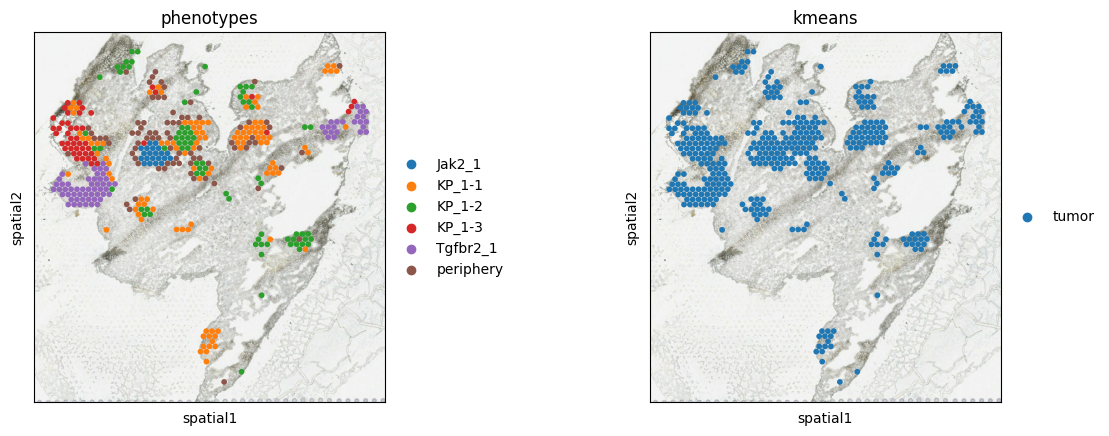

In [6]:
sc.pl.spatial(flux, img_key="hires", color=["phenotypes", 'kmeans'], size=1.5)

In [7]:
# minimal deps: scanpy, pandas, pathlib
import scanpy as sc
import pandas as pd
from pathlib import Path

# -----------------------------------------------------
# CONFIGURATION (parallel to RNA pipeline)
# -----------------------------------------------------
CASE        = "Tgfbr2_1"
CONTROLS    = ["KP_1-1", "KP_1-2", "KP_1-3", "periphery"]
GROUPBY     = "phenotypes"      # must exist in flux.obs
ALPHA       = 0.05              # FDR threshold
OUTDIR      = Path("./GSEAPY_Enrichr_Only_Flux")   # flux results folder
# -----------------------------------------------------

OUTDIR.mkdir(parents=True, exist_ok=True)

print("\n[INFO] Running differential metabolite/flux analysis…")
summary_rows = []

for ctrl in CONTROLS:
    cmp_name = f"{CASE}_vs_{ctrl}"
    print(f"\n[INFO] {cmp_name}: DE on fluxomics")

    # =====================================================
    # 1) Rank groups (same as RNA but using flux AnnData)
    # =====================================================
    sc.tl.rank_genes_groups(
        flux,
        groupby=GROUPBY,
        groups=[CASE],            # always list-like
        reference=ctrl,
        method="t-test",
        use_raw=False,
        tie_correct=True,
    )

    # =====================================================
    # 2) Extract differentials and filter by padj < 0.05
    # =====================================================
    res_df = sc.get.rank_genes_groups_df(flux, group=CASE)

    # Keep main DE columns
    keep_cols = ["names", "scores", "logfoldchanges", "pvals", "pvals_adj"]
    de_df     = res_df.loc[res_df["pvals_adj"] < ALPHA, keep_cols].copy()

    # Save results even if empty (for consistency)
    run_dir = OUTDIR / cmp_name
    run_dir.mkdir(parents=True, exist_ok=True)

    de_path = run_dir / "DE_Flux_padj_lt_0.05.csv"
    de_df.to_csv(de_path, index=False)

    print(f"[OK] Saved: {de_path}")

    # keep for summary
    summary_rows.append({"comparison": cmp_name,
                         "n_sig": de_df.shape[0]})

# =====================================================
# Write summary file
# =====================================================
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(OUTDIR / "flux_DE_summary.csv", index=False)

print("\n[OK] Summary saved:", OUTDIR / "flux_DE_summary.csv")
print("[DONE] Fluxomics DE analysis complete.")


[INFO] Running differential metabolite/flux analysis…

[INFO] Tgfbr2_1_vs_KP_1-1: DE on fluxomics
[OK] Saved: GSEAPY_Enrichr_Only_Flux/Tgfbr2_1_vs_KP_1-1/DE_Flux_padj_lt_0.05.csv

[INFO] Tgfbr2_1_vs_KP_1-2: DE on fluxomics
[OK] Saved: GSEAPY_Enrichr_Only_Flux/Tgfbr2_1_vs_KP_1-2/DE_Flux_padj_lt_0.05.csv

[INFO] Tgfbr2_1_vs_KP_1-3: DE on fluxomics
[OK] Saved: GSEAPY_Enrichr_Only_Flux/Tgfbr2_1_vs_KP_1-3/DE_Flux_padj_lt_0.05.csv

[INFO] Tgfbr2_1_vs_periphery: DE on fluxomics
[OK] Saved: GSEAPY_Enrichr_Only_Flux/Tgfbr2_1_vs_periphery/DE_Flux_padj_lt_0.05.csv

[OK] Summary saved: GSEAPY_Enrichr_Only_Flux/flux_DE_summary.csv
[DONE] Fluxomics DE analysis complete.


invalid value encountered in log2
invalid value encountered in log2
invalid value encountered in log2
invalid value encountered in log2


# Visualisations

## Flux

In [1]:
!pwd

/home/ggavriilidis/Mongoose/Scripts


In [11]:
from adjustText import adjust_text

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


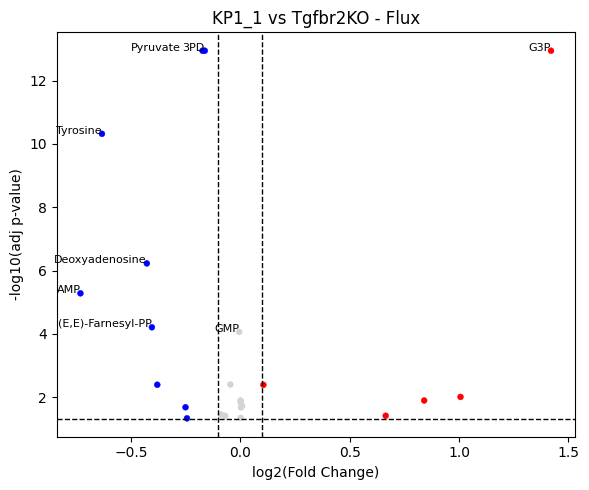

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ============================================================
# 1. Load your DE table
# ============================================================
df = pd.read_csv("GSEAPY_Enrichr_Only_Flux/Tgfbr2_1_vs_KP_1-1/DE_Flux_padj_lt_0.05.csv")

# --- Modify these if your column names differ ---
gene_col = "names"
logfc_col = "logfoldchanges"
pval_col = "pvals_adj"

df = df.rename(columns={
    gene_col: "gene",
    logfc_col: "logFC",
    pval_col: "padj"
})

# Drop NA padj
df = df.dropna(subset=["padj"])

# ============================================================
# 2. Create volcano variables
# ============================================================
df["neglog10padj"] = -np.log10(df["padj"])

# Significance thresholds
padj_thresh = 0.05
logfc_thresh = 0.1

df["significant"] = (
    (df["padj"] < padj_thresh) &
    (np.abs(df["logFC"]) >= logfc_thresh)
)

df["color"] = df["significant"].map({True: "#d62728", False: "lightgray"})
df.loc[df["logFC"] < -logfc_thresh, "color"] = "#1f77b4"

# ============================================================
# 3. Plot
# ============================================================
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df,
    x="logFC",
    y="neglog10padj",
    hue="color",
    palette={"#d62728": "red", "lightgray": "lightgray", "#1f77b4": "blue"},
    legend=False,
    s=18,
    edgecolor=None,
)

# Threshold lines
plt.axhline(-np.log10(padj_thresh), linestyle="--", color="black", linewidth=1)
plt.axvline(logfc_thresh, linestyle="--", color="black", linewidth=1)
plt.axvline(-logfc_thresh, linestyle="--", color="black", linewidth=1)

# ============================================================
# 4. Label top genes (manual Pyruvate offset)
# ============================================================
top_genes = df.nsmallest(10, "padj")

for _, row in top_genes.iterrows():

    x = row["logFC"]
    y = row["neglog10padj"]
    label = row["gene"]

    # ---- MOVE Pyruvate label slightly left ----
    if label.lower().startswith("pyruvate"):
        x = x - 0.1  # shift left (increase if you want more movement)

    plt.text(
        x,
        y,
        label,
        fontsize=8,
        ha="right"
    )


plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(adj p-value)")
plt.title("KP1_1 vs Tgfbr2KO - Flux")
plt.tight_layout()


plt.savefig("../Figures/volcano_flux_KP1-1_vs_tgfbr2.png", dpi=300, bbox_inches="tight")

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


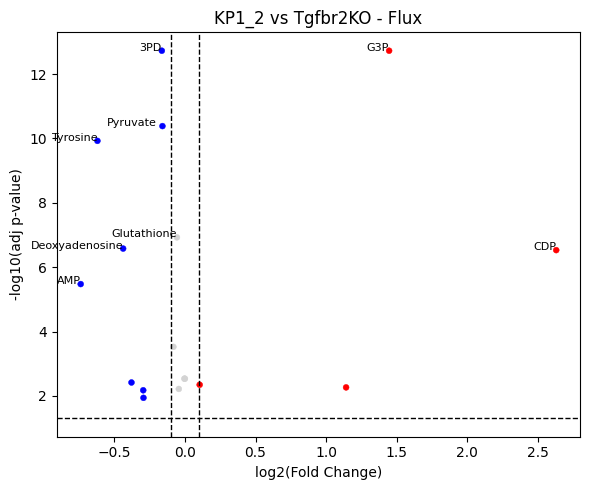

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ============================================================
# 1. Load your DE table
# ============================================================
df = pd.read_csv("GSEAPY_Enrichr_Only_Flux/Tgfbr2_1_vs_KP_1-2/DE_Flux_padj_lt_0.05.csv")

# --- Modify these if your column names differ ---
gene_col = "names"
logfc_col = "logfoldchanges"
pval_col = "pvals_adj"

df = df.rename(columns={
    gene_col: "gene",
    logfc_col: "logFC",
    pval_col: "padj"
})

# Drop NA padj
df = df.dropna(subset=["padj"])

# ============================================================
# 2. Create volcano variables
# ============================================================
df["neglog10padj"] = -np.log10(df["padj"])

# Significance thresholds
padj_thresh = 0.05
logfc_thresh = 0.1

df["significant"] = (
    (df["padj"] < padj_thresh) &
    (np.abs(df["logFC"]) >= logfc_thresh)
)

df["color"] = df["significant"].map({True: "#d62728", False: "lightgray"})
df.loc[df["logFC"] < -logfc_thresh, "color"] = "#1f77b4"

# ============================================================
# 3. Plot
# ============================================================
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df,
    x="logFC",
    y="neglog10padj",
    hue="color",
    palette={"#d62728": "red", "lightgray": "lightgray", "#1f77b4": "blue"},
    legend=False,
    s=18,
    edgecolor=None,
)

# Threshold lines
plt.axhline(-np.log10(padj_thresh), linestyle="--", color="black", linewidth=1)
plt.axvline(logfc_thresh, linestyle="--", color="black", linewidth=1)
plt.axvline(-logfc_thresh, linestyle="--", color="black", linewidth=1)

# ============================================================
# 4. Label top genes (manual Pyruvate offset)
# ============================================================
top_genes = df.nsmallest(10, "padj")

for _, row in top_genes.iterrows():

    x = row["logFC"]
    y = row["neglog10padj"]
    label = row["gene"]

    # ---- MOVE Pyruvate label slightly left ----
    if label.lower().startswith("pyruvate"):
        x = x - 0.04  # shift left (increase if you want more movement)

    plt.text(
        x,
        y,
        label,
        fontsize=8,
        ha="right"
    )


plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(adj p-value)")
plt.title("KP1_2 vs Tgfbr2KO - Flux")
plt.tight_layout()


plt.savefig("../Figures/volcano_flux_KP1-2_vs_tgfbr2.png", dpi=300, bbox_inches="tight")

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


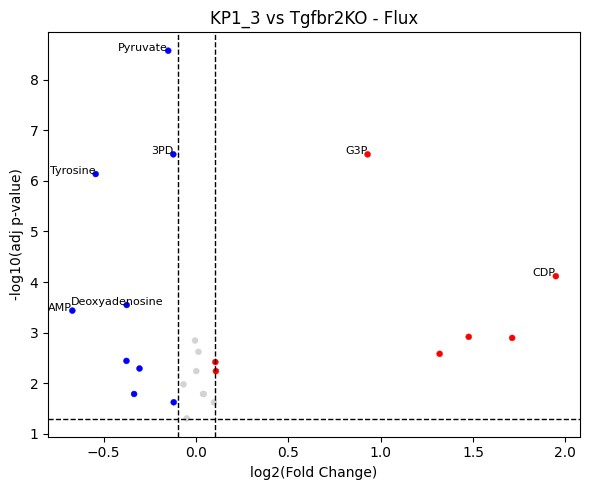

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ============================================================
# 1. Load your DE table
# ============================================================
df = pd.read_csv("GSEAPY_Enrichr_Only_Flux/Tgfbr2_1_vs_KP_1-3/DE_Flux_padj_lt_0.05.csv")

# --- Modify these if your column names differ ---
gene_col = "names"
logfc_col = "logfoldchanges"
pval_col = "pvals_adj"

df = df.rename(columns={
    gene_col: "gene",
    logfc_col: "logFC",
    pval_col: "padj"
})

# Drop NA padj
df = df.dropna(subset=["padj"])

# ============================================================
# 2. Create volcano variables
# ============================================================
df["neglog10padj"] = -np.log10(df["padj"])

# Significance thresholds
padj_thresh = 0.05
logfc_thresh = 0.1

df["significant"] = (
    (df["padj"] < padj_thresh) &
    (np.abs(df["logFC"]) >= logfc_thresh)
)

df["color"] = df["significant"].map({True: "#d62728", False: "lightgray"})
df.loc[df["logFC"] < -logfc_thresh, "color"] = "#1f77b4"

# ============================================================
# 3. Plot
# ============================================================
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df,
    x="logFC",
    y="neglog10padj",
    hue="color",
    palette={"#d62728": "red", "lightgray": "lightgray", "#1f77b4": "blue"},
    legend=False,
    s=18,
    edgecolor=None,
)

# Threshold lines
plt.axhline(-np.log10(padj_thresh), linestyle="--", color="black", linewidth=1)
plt.axvline(logfc_thresh, linestyle="--", color="black", linewidth=1)
plt.axvline(-logfc_thresh, linestyle="--", color="black", linewidth=1)

# ============================================================
# 4. Label top genes (manual Pyruvate offset)
# ============================================================
top_genes = df.nsmallest(10, "padj")

for _, row in top_genes.iterrows():

    x = row["logFC"]
    y = row["neglog10padj"]
    label = row["gene"]

    # ---- MOVE Pyruvate label slightly left ----
    if label.lower().startswith("deoxyadenosine"):
        x = x + 0.2  # shift left (increase if you want more movement)

    plt.text(
        x,
        y,
        label,
        fontsize=8,
        ha="right"
    )


plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(adj p-value)")
plt.title("KP1_3 vs Tgfbr2KO - Flux")
plt.tight_layout()


plt.savefig("../Figures/volcano_flux_KP1-3_vs_tgfbr2.png", dpi=300, bbox_inches="tight")

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


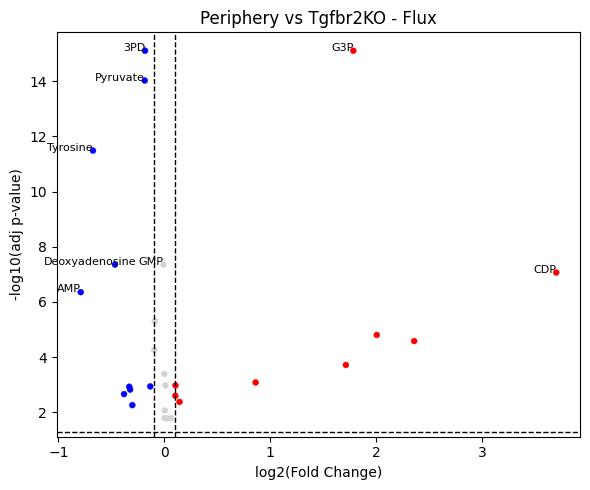

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ============================================================
# 1. Load your DE table
# ============================================================
df = pd.read_csv("GSEAPY_Enrichr_Only_Flux/Tgfbr2_1_vs_periphery/DE_Flux_padj_lt_0.05.csv")

# --- Modify these if your column names differ ---
gene_col = "names"
logfc_col = "logfoldchanges"
pval_col = "pvals_adj"

df = df.rename(columns={
    gene_col: "gene",
    logfc_col: "logFC",
    pval_col: "padj"
})

# Drop NA padj
df = df.dropna(subset=["padj"])

# ============================================================
# 2. Create volcano variables
# ============================================================
df["neglog10padj"] = -np.log10(df["padj"])

# Significance thresholds
padj_thresh = 0.05
logfc_thresh = 0.1

df["significant"] = (
    (df["padj"] < padj_thresh) &
    (np.abs(df["logFC"]) >= logfc_thresh)
)

df["color"] = df["significant"].map({True: "#d62728", False: "lightgray"})
df.loc[df["logFC"] < -logfc_thresh, "color"] = "#1f77b4"

# ============================================================
# 3. Plot
# ============================================================
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df,
    x="logFC",
    y="neglog10padj",
    hue="color",
    palette={"#d62728": "red", "lightgray": "lightgray", "#1f77b4": "blue"},
    legend=False,
    s=18,
    edgecolor=None,
)

# Threshold lines
plt.axhline(-np.log10(padj_thresh), linestyle="--", color="black", linewidth=1)
plt.axvline(logfc_thresh, linestyle="--", color="black", linewidth=1)
plt.axvline(-logfc_thresh, linestyle="--", color="black", linewidth=1)

# ============================================================
# 4. Label top genes (manual Pyruvate offset)
# ============================================================
top_genes = df.nsmallest(10, "padj")

for _, row in top_genes.iterrows():

    x = row["logFC"]
    y = row["neglog10padj"]
    label = row["gene"]

    # ---- MOVE Pyruvate label slightly left ----
    if label.lower().startswith("deoxyadenosine"):
        x = x + 0.2  # shift left (increase if you want more movement)

    plt.text(
        x,
        y,
        label,
        fontsize=8,
        ha="right"
    )


plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(adj p-value)")
plt.title("Periphery vs Tgfbr2KO - Flux")
plt.tight_layout()

plt.savefig("../Figures/volcano_flux_periphery_vs_tgfbr2.png", dpi=300, bbox_inches="tight")

plt.show()

## RNA

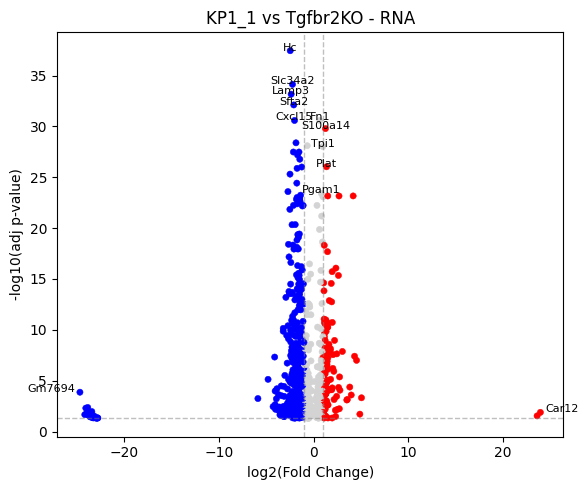

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ============================================================
# 1. Load your DE table
# ============================================================
df = pd.read_csv("GSEAPY_Enrichr_Only/Tgfbr2_1_vs_KP_1-1/DEGs_padj_lt_0.05.csv")

df = df.rename(columns={
    "names": "gene",
    "logfoldchanges": "logFC",
    "pvals_adj": "padj"
})

df = df.dropna(subset=["padj"])

# ============================================================
# 2. Create volcano variables
# ============================================================
df["neglog10padj"] = -np.log10(df["padj"])

padj_thresh = 0.05
logfc_thresh = 1.0

df["significant"] = (
    (df["padj"] < padj_thresh) &
    (np.abs(df["logFC"]) >= logfc_thresh)
)

df["color"] = "lightgray"
df.loc[(df["significant"]) & (df["logFC"] > 0), "color"] = "red"
df.loc[(df["significant"]) & (df["logFC"] < 0), "color"] = "blue"

# ============================================================
# 3. Plot
# ============================================================
plt.figure(figsize=(6, 5))

sns.scatterplot(
    data=df,
    x="logFC",
    y="neglog10padj",
    hue="color",
    palette={"red": "red", "blue": "blue", "lightgray": "lightgray"},
    legend=False,
    s=20,
    edgecolor=None,
)

# Threshold lines (grey + transparent)
plt.axhline(-np.log10(padj_thresh), linestyle="--", color="grey", alpha=0.5, linewidth=1)
plt.axvline(logfc_thresh, linestyle="--", color="grey", alpha=0.5, linewidth=1)
plt.axvline(-logfc_thresh, linestyle="--", color="grey", alpha=0.5, linewidth=1)

# ============================================================
# 4. Label genes
# ============================================================

# --- Label extreme left & right ---
left_gene = df.loc[df["logFC"].idxmin()]
right_gene = df.loc[df["logFC"].idxmax()]

plt.text(
    left_gene["logFC"] - 0.5,
    left_gene["neglog10padj"],
    left_gene["gene"],
    fontsize=8,
    ha="right",
    color="black"
)

plt.text(
    right_gene["logFC"] + 0.5,
    right_gene["neglog10padj"],
    right_gene["gene"],
    fontsize=8,
    ha="left",
    color="black"
)

# --- Label top 5 up & top 5 down significant genes ---
top_up = df[df["logFC"] > 0].nsmallest(5, "padj")
top_down = df[df["logFC"] < 0].nsmallest(5, "padj")
top_genes = pd.concat([top_up, top_down])

for _, row in top_genes.iterrows():
    plt.text(
        row["logFC"],
        row["neglog10padj"],
        row["gene"],
        fontsize=8,
        ha="center",
        color="black"
    )

# ============================================================
# 5. Aesthetics, save & show
# ============================================================
plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(adj p-value)")
plt.title("KP1_1 vs Tgfbr2KO - RNA")
plt.tight_layout()

plt.savefig("../Figures/volcano_RNA_KP1-1_vs_tgfbr2.png", dpi=300, bbox_inches="tight")
plt.show()

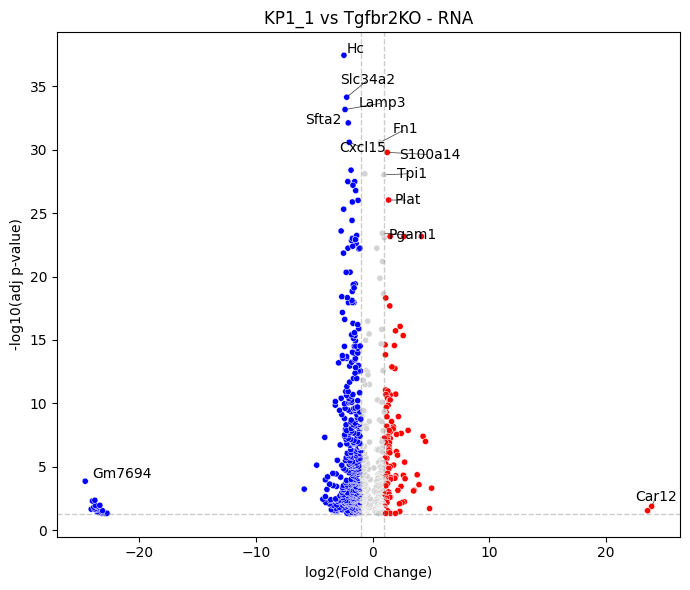

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from adjustText import adjust_text

# ============================================================
# 1. Load DE table
# ============================================================
df = pd.read_csv("GSEAPY_Enrichr_Only/Tgfbr2_1_vs_KP_1-1/DEGs_padj_lt_0.05.csv")

df = df.rename(columns={
    "names": "gene",
    "logfoldchanges": "logFC",
    "pvals_adj": "padj"
})

df = df.dropna(subset=["padj"])
df["neglog10padj"] = -np.log10(df["padj"])

padj_thresh = 0.05
logfc_thresh = 1.0

df["significant"] = (
    (df["padj"] < padj_thresh) &
    (np.abs(df["logFC"]) >= logfc_thresh)
)

df["color"] = "lightgray"
df.loc[(df["significant"]) & (df["logFC"] > 0), "color"] = "red"
df.loc[(df["significant"]) & (df["logFC"] < 0), "color"] = "blue"


# ============================================================
# 2. Plot
# ============================================================
plt.figure(figsize=(7, 6))

sns.scatterplot(
    data=df,
    x="logFC",
    y="neglog10padj",
    hue="color",
    palette={"red": "red", "blue": "blue", "lightgray": "lightgray"},
    legend=False,
    s=20
)

# Grey transparent dashed threshold lines
plt.axhline(-np.log10(padj_thresh), linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(-logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)


# ============================================================
# 3. Labeling (repelled)
# ============================================================

texts = []

# Extreme left & right genes
left_gene = df.loc[df["logFC"].idxmin()]
right_gene = df.loc[df["logFC"].idxmax()]

for row in [left_gene, right_gene]:
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )

# Top 5 up/down significant genes
top_up = df[df["logFC"] > 0].nsmallest(5, "padj")
top_down = df[df["logFC"] < 0].nsmallest(5, "padj")
top_genes = pd.concat([top_up, top_down])

for _, row in top_genes.iterrows():
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )

# Apply repel adjustment
adjust_text(
    texts,
    force_points=0.3,
    force_text=0.3,
    expand_points=(1.2, 1.4),
    expand_text=(1.1, 1.3),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5, alpha=0.8)
)

# ============================================================
# 4. Aesthetics
# ============================================================
plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(adj p-value)")
plt.title("KP1_1 vs Tgfbr2KO - RNA")
plt.tight_layout()

plt.savefig("../Figures/volcano_RNA_KP1-1_vs_tgfbr2.png", dpi=300, bbox_inches="tight")
plt.show()

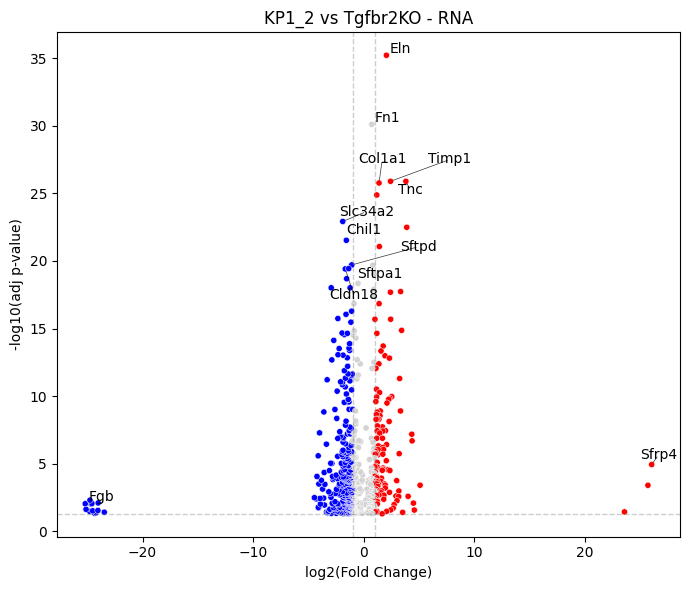

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from adjustText import adjust_text

# ============================================================
# 1. Load DE table
# ============================================================
df = pd.read_csv("GSEAPY_Enrichr_Only/Tgfbr2_1_vs_KP_1-2/DEGs_padj_lt_0.05.csv")

df = df.rename(columns={
    "names": "gene",
    "logfoldchanges": "logFC",
    "pvals_adj": "padj"
})

df = df.dropna(subset=["padj"])
df["neglog10padj"] = -np.log10(df["padj"])

padj_thresh = 0.05
logfc_thresh = 1.0

df["significant"] = (
    (df["padj"] < padj_thresh) &
    (np.abs(df["logFC"]) >= logfc_thresh)
)

df["color"] = "lightgray"
df.loc[(df["significant"]) & (df["logFC"] > 0), "color"] = "red"
df.loc[(df["significant"]) & (df["logFC"] < 0), "color"] = "blue"


# ============================================================
# 2. Plot
# ============================================================
plt.figure(figsize=(7, 6))

sns.scatterplot(
    data=df,
    x="logFC",
    y="neglog10padj",
    hue="color",
    palette={"red": "red", "blue": "blue", "lightgray": "lightgray"},
    legend=False,
    s=20
)

# Grey transparent dashed threshold lines
plt.axhline(-np.log10(padj_thresh), linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(-logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)


# ============================================================
# 3. Labeling (repelled)
# ============================================================

texts = []

# Extreme left & right genes
left_gene = df.loc[df["logFC"].idxmin()]
right_gene = df.loc[df["logFC"].idxmax()]

for row in [left_gene, right_gene]:
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )

# Top 5 up/down significant genes
top_up = df[df["logFC"] > 0].nsmallest(5, "padj")
top_down = df[df["logFC"] < 0].nsmallest(5, "padj")
top_genes = pd.concat([top_up, top_down])

for _, row in top_genes.iterrows():
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )


adjust_text(
    texts,
    force_points=1.0,      # stronger push away from datapoints
    force_text=1.0,        # stronger push between labels
    expand_points=(2.0, 2.5),
    expand_text=(1.8, 2.2),
    only_move={'points':'y', 'text':'xy'}, 
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5, alpha=0.8)
)


# ============================================================
# 4. Aesthetics
# ============================================================
plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(adj p-value)")
plt.title("KP1_2 vs Tgfbr2KO - RNA")
plt.tight_layout()

plt.savefig("../Figures/volcano_RNA_KP1-2_vs_tgfbr2.png", dpi=300, bbox_inches="tight")
plt.show()

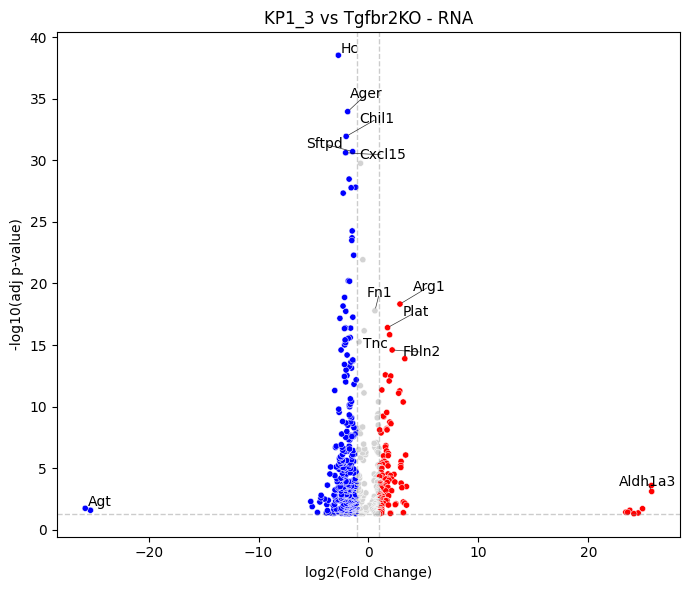

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from adjustText import adjust_text

# ============================================================
# 1. Load DE table
# ============================================================
df = pd.read_csv("GSEAPY_Enrichr_Only/Tgfbr2_1_vs_KP_1-3/DEGs_padj_lt_0.05.csv")

df = df.rename(columns={
    "names": "gene",
    "logfoldchanges": "logFC",
    "pvals_adj": "padj"
})

df = df.dropna(subset=["padj"])
df["neglog10padj"] = -np.log10(df["padj"])

padj_thresh = 0.05
logfc_thresh = 1.0

df["significant"] = (
    (df["padj"] < padj_thresh) &
    (np.abs(df["logFC"]) >= logfc_thresh)
)

df["color"] = "lightgray"
df.loc[(df["significant"]) & (df["logFC"] > 0), "color"] = "red"
df.loc[(df["significant"]) & (df["logFC"] < 0), "color"] = "blue"


# ============================================================
# 2. Plot
# ============================================================
plt.figure(figsize=(7, 6))

sns.scatterplot(
    data=df,
    x="logFC",
    y="neglog10padj",
    hue="color",
    palette={"red": "red", "blue": "blue", "lightgray": "lightgray"},
    legend=False,
    s=20
)

# Grey transparent dashed threshold lines
plt.axhline(-np.log10(padj_thresh), linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(-logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)


# ============================================================
# 3. Labeling (repelled)
# ============================================================

texts = []

# Extreme left & right genes
left_gene = df.loc[df["logFC"].idxmin()]
right_gene = df.loc[df["logFC"].idxmax()]

for row in [left_gene, right_gene]:
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )

# Top 5 up/down significant genes
top_up = df[df["logFC"] > 0].nsmallest(5, "padj")
top_down = df[df["logFC"] < 0].nsmallest(5, "padj")
top_genes = pd.concat([top_up, top_down])

for _, row in top_genes.iterrows():
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )


adjust_text(
    texts,
    force_points=1.0,      # stronger push away from datapoints
    force_text=1.0,        # stronger push between labels
    expand_points=(2.0, 2.5),
    expand_text=(1.8, 2.2),
    only_move={'points':'y', 'text':'xy'}, 
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5, alpha=0.8)
)


# ============================================================
# 4. Aesthetics
# ============================================================
plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(adj p-value)")
plt.title("KP1_3 vs Tgfbr2KO - RNA")
plt.tight_layout()

plt.savefig("../Figures/volcano_RNA_KP1-3_vs_tgfbr2.png", dpi=300, bbox_inches="tight")
plt.show()

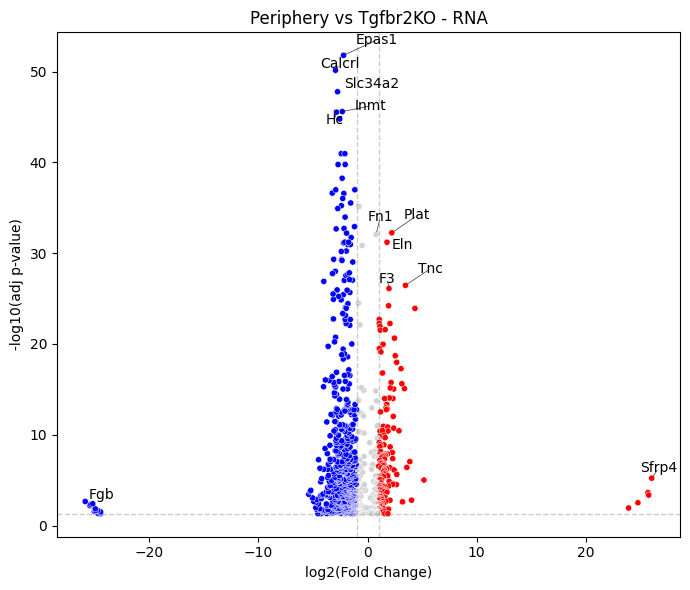

In [50]:
df = pd.read_csv("GSEAPY_Enrichr_Only/Tgfbr2_1_vs_periphery/DEGs_padj_lt_0.05.csv")

df = df.rename(columns={
    "names": "gene",
    "logfoldchanges": "logFC",
    "pvals_adj": "padj"
})

df = df.dropna(subset=["padj"])
df["neglog10padj"] = -np.log10(df["padj"])

padj_thresh = 0.05
logfc_thresh = 1.0

df["significant"] = (
    (df["padj"] < padj_thresh) &
    (np.abs(df["logFC"]) >= logfc_thresh)
)

df["color"] = "lightgray"
df.loc[(df["significant"]) & (df["logFC"] > 0), "color"] = "red"
df.loc[(df["significant"]) & (df["logFC"] < 0), "color"] = "blue"


# ============================================================
# 2. Plot
# ============================================================
plt.figure(figsize=(7, 6))

sns.scatterplot(
    data=df,
    x="logFC",
    y="neglog10padj",
    hue="color",
    palette={"red": "red", "blue": "blue", "lightgray": "lightgray"},
    legend=False,
    s=20
)

# Grey transparent dashed threshold lines
plt.axhline(-np.log10(padj_thresh), linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(-logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)


# ============================================================
# 3. Labeling (repelled)
# ============================================================

texts = []

# Extreme left & right genes
left_gene = df.loc[df["logFC"].idxmin()]
right_gene = df.loc[df["logFC"].idxmax()]

for row in [left_gene, right_gene]:
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )

# Top 5 up/down significant genes
top_up = df[df["logFC"] > 0].nsmallest(5, "padj")
top_down = df[df["logFC"] < 0].nsmallest(5, "padj")
top_genes = pd.concat([top_up, top_down])

for _, row in top_genes.iterrows():
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )


adjust_text(
    texts,
    force_points=1.0,      # stronger push away from datapoints
    force_text=1.0,        # stronger push between labels
    expand_points=(2.0, 2.5),
    expand_text=(1.8, 2.2),
    only_move={'points':'y', 'text':'xy'}, 
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5, alpha=0.8)
)


# ============================================================
# 4. Aesthetics
# ============================================================
plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(adj p-value)")
plt.title("Periphery vs Tgfbr2KO - RNA")
plt.tight_layout()

plt.savefig("../Figures/volcano_RNA_Periphery_vs_tgfbr2.png", dpi=300, bbox_inches="tight")
plt.show()

## Niche

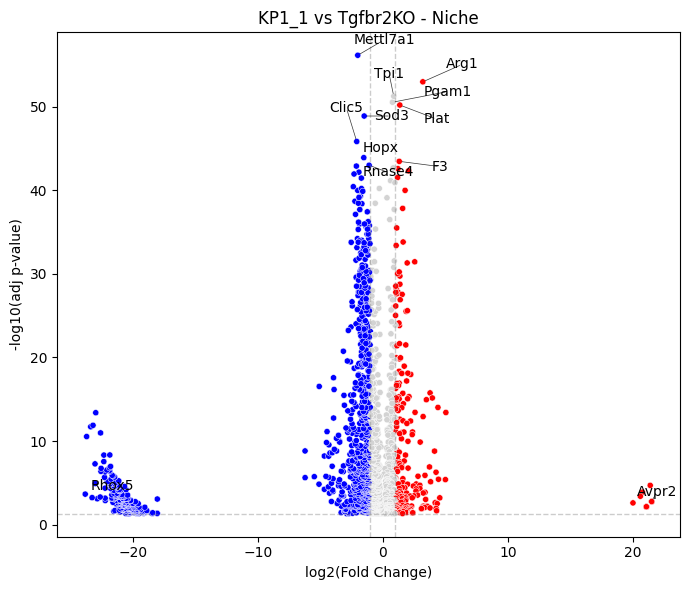

In [55]:
df = pd.read_csv("GSEAPY_Enrichr_Only_Niche/Tgfbr2_1_vs_KP_1-1/DEGs_padj_lt_0.05.csv")

df = df.rename(columns={
    "names": "gene",
    "logfoldchanges": "logFC",
    "pvals_adj": "padj"
})

df = df.dropna(subset=["padj"])
df["neglog10padj"] = -np.log10(df["padj"])

padj_thresh = 0.05
logfc_thresh = 1.0

df["significant"] = (
    (df["padj"] < padj_thresh) &
    (np.abs(df["logFC"]) >= logfc_thresh)
)

df["color"] = "lightgray"
df.loc[(df["significant"]) & (df["logFC"] > 0), "color"] = "red"
df.loc[(df["significant"]) & (df["logFC"] < 0), "color"] = "blue"


# ============================================================
# 2. Plot
# ============================================================
plt.figure(figsize=(7, 6))

sns.scatterplot(
    data=df,
    x="logFC",
    y="neglog10padj",
    hue="color",
    palette={"red": "red", "blue": "blue", "lightgray": "lightgray"},
    legend=False,
    s=20
)

# Grey transparent dashed threshold lines
plt.axhline(-np.log10(padj_thresh), linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(-logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)


# ============================================================
# 3. Labeling (repelled)
# ============================================================

texts = []

# Extreme left & right genes
left_gene = df.loc[df["logFC"].idxmin()]
right_gene = df.loc[df["logFC"].idxmax()]

for row in [left_gene, right_gene]:
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )

# Top 5 up/down significant genes
top_up = df[df["logFC"] > 0].nsmallest(5, "padj")
top_down = df[df["logFC"] < 0].nsmallest(5, "padj")
top_genes = pd.concat([top_up, top_down])

for _, row in top_genes.iterrows():
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )


adjust_text(
    texts,
    force_points=1.0,      # stronger push away from datapoints
    force_text=1.0,        # stronger push between labels
    expand_points=(2.0, 2.5),
    expand_text=(1.8, 2.2),
    only_move={'points':'y', 'text':'xy'}, 
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5, alpha=0.8)
)


# ============================================================
# 4. Aesthetics
# ============================================================
plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(adj p-value)")
plt.title("KP1_1 vs Tgfbr2KO - Niche")
plt.tight_layout()

plt.savefig("../Figures/volcano_Niche_KP1-1_vs_tgfbr2.png", dpi=300, bbox_inches="tight")
plt.show()

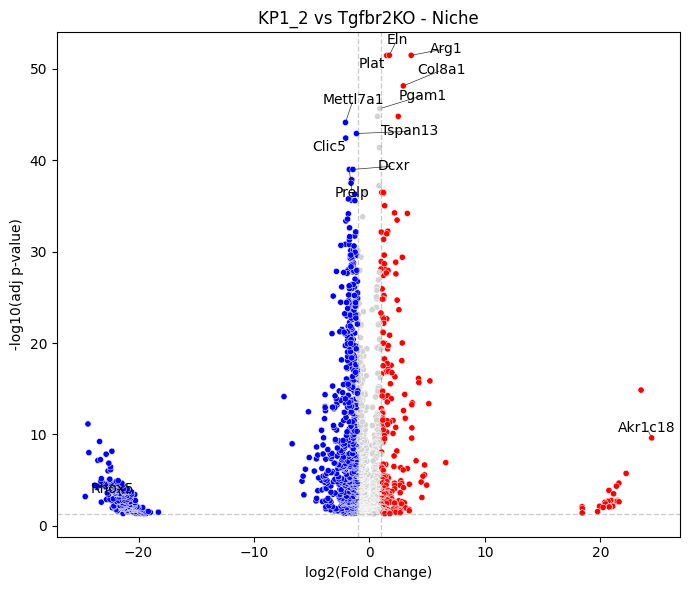

In [57]:
df = pd.read_csv("GSEAPY_Enrichr_Only_Niche/Tgfbr2_1_vs_KP_1-2/DEGs_padj_lt_0.05_niche.csv")

df = df.rename(columns={
    "names": "gene",
    "logfoldchanges": "logFC",
    "pvals_adj": "padj"
})

df = df.dropna(subset=["padj"])
df["neglog10padj"] = -np.log10(df["padj"])

padj_thresh = 0.05
logfc_thresh = 1.0

df["significant"] = (
    (df["padj"] < padj_thresh) &
    (np.abs(df["logFC"]) >= logfc_thresh)
)

df["color"] = "lightgray"
df.loc[(df["significant"]) & (df["logFC"] > 0), "color"] = "red"
df.loc[(df["significant"]) & (df["logFC"] < 0), "color"] = "blue"


# ============================================================
# 2. Plot
# ============================================================
plt.figure(figsize=(7, 6))

sns.scatterplot(
    data=df,
    x="logFC",
    y="neglog10padj",
    hue="color",
    palette={"red": "red", "blue": "blue", "lightgray": "lightgray"},
    legend=False,
    s=20
)

# Grey transparent dashed threshold lines
plt.axhline(-np.log10(padj_thresh), linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(-logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)


# ============================================================
# 3. Labeling (repelled)
# ============================================================

texts = []

# Extreme left & right genes
left_gene = df.loc[df["logFC"].idxmin()]
right_gene = df.loc[df["logFC"].idxmax()]

for row in [left_gene, right_gene]:
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )

# Top 5 up/down significant genes
top_up = df[df["logFC"] > 0].nsmallest(5, "padj")
top_down = df[df["logFC"] < 0].nsmallest(5, "padj")
top_genes = pd.concat([top_up, top_down])

for _, row in top_genes.iterrows():
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )


adjust_text(
    texts,
    force_points=1.0,      # stronger push away from datapoints
    force_text=1.0,        # stronger push between labels
    expand_points=(2.0, 2.5),
    expand_text=(1.8, 2.2),
    only_move={'points':'y', 'text':'xy'}, 
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5, alpha=0.8)
)


# ============================================================
# 4. Aesthetics
# ============================================================
plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(adj p-value)")
plt.title("KP1_2 vs Tgfbr2KO - Niche")
plt.tight_layout()

plt.savefig("../Figures/volcano_Niche_KP1-2_vs_tgfbr2.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
df = pd.read_csv("GSEAPY_Enrichr_Only_Niche/Tgfbr2_1_vs_KP_1-3/DEGs_padj_lt_0.05.csv")

df = df.rename(columns={
    "names": "gene",
    "logfoldchanges": "logFC",
    "pvals_adj": "padj"
})

df = df.dropna(subset=["padj"])
df["neglog10padj"] = -np.log10(df["padj"])

padj_thresh = 0.05
logfc_thresh = 1.0

df["significant"] = (
    (df["padj"] < padj_thresh) &
    (np.abs(df["logFC"]) >= logfc_thresh)
)

df["color"] = "lightgray"
df.loc[(df["significant"]) & (df["logFC"] > 0), "color"] = "red"
df.loc[(df["significant"]) & (df["logFC"] < 0), "color"] = "blue"


# ============================================================
# 2. Plot
# ============================================================
plt.figure(figsize=(7, 6))

sns.scatterplot(
    data=df,
    x="logFC",
    y="neglog10padj",
    hue="color",
    palette={"red": "red", "blue": "blue", "lightgray": "lightgray"},
    legend=False,
    s=20
)

# Grey transparent dashed threshold lines
plt.axhline(-np.log10(padj_thresh), linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)
plt.axvline(-logfc_thresh, linestyle="--", color="grey", alpha=0.4, linewidth=1)


# ============================================================
# 3. Labeling (repelled)
# ============================================================

texts = []

# Extreme left & right genes
left_gene = df.loc[df["logFC"].idxmin()]
right_gene = df.loc[df["logFC"].idxmax()]

for row in [left_gene, right_gene]:
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )

# Top 5 up/down significant genes
top_up = df[df["logFC"] > 0].nsmallest(5, "padj")
top_down = df[df["logFC"] < 0].nsmallest(5, "padj")
top_genes = pd.concat([top_up, top_down])

for _, row in top_genes.iterrows():
    texts.append(
        plt.text(
            row["logFC"],
            row["neglog10padj"],
            row["gene"],
            fontsize=10,
            color="black"
        )
    )


adjust_text(
    texts,
    force_points=1.0,      # stronger push away from datapoints
    force_text=1.0,        # stronger push between labels
    expand_points=(2.0, 2.5),
    expand_text=(1.8, 2.2),
    only_move={'points':'y', 'text':'xy'}, 
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5, alpha=0.8)
)


# ============================================================
# 4. Aesthetics
# ============================================================
plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(adj p-value)")
plt.title("KP1_2 vs Tgfbr2KO - Niche")
plt.tight_layout()

plt.savefig("../Figures/volcano_Niche_KP1-2_vs_tgfbr2.png", dpi=300, bbox_inches="tight")
plt.show()